In [3]:
import numpy as np
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import sys
sys.path.append('../python_scripts/')
import analysis, datasets
sys.path.append('../imported_code/svcca/')
import cca_core, pwcca

In [4]:
'''
RSA: Create an RDM for each activation layer (90 total) and get correlations between pairings of RDMs
'''
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Flatten
from scipy.stats import pearsonr, spearmanr
import os
_, testData = correlations.make_train_data()
x_predict, y_predict = correlations.make_predict_data(testData)
# Function to correlate 2 RDMs
def correlate(RDM_1, RDM_2):
    print('Making correlations...')
    assert len(RDM_1) == len(RDM_2)
    # first flatten all the relevant values
    arr_1 = RDM_1[np.triu_indices(n=num_imgs, k=1)]
    arr_2 = RDM_2[np.triu_indices(n=num_imgs, k=1)]
    # Get Pearson correlation
    return pearsonr(arr_1, arr_2)[0]


num_imgs = len(x_predict) # 1000
RDM_list = np.empty((90, 1000, 1000)) #layer * instance, images, images
# Loop through network instances
index = 0
for i in [200, 202, 203, 206, 207, 302, 303, 304, 305, 306]:
    print('Working on model', str(i))
    K.clear_session()
    full_model = load_model('../outputs/models/primary/instance_' + str(i) + '.h5')
    inp = full_model.input
    # Loop through layers
    for j in range(0, 9):
        print('Layer', str(j))
        out = full_model.layers[j].output
        # Flatten representation if needed
        if len(out.shape) != 2:
            out = Flatten()(out)
        temp_model = Model(inputs=inp, outputs=out)
        # Predict on x_predict, transpose for spearman
        print('Getting representation...')
        representations = temp_model.predict(x_predict).T
        print(representations.shape)
        print('Getting RDM...')
        RDM_list[10 * j + index] = spearmanr(representations, representations)[0][:num_imgs, :num_imgs]
    index += 1
 
np.save('RDM_list.npy', RDM_list)
print('Done gathering RDMs, now correlations')
RDM_list = np.load('RDM_list.npy')
correlations = np.empty((90, 90))
for i in range(correlations.shape[0]):
    for j in range(correlations.shape[1]):
        print('Correlation', str(i), ',', str(j))
        correlations[i, j] = correlate(RDM_list[i], RDM_list[j])

np.save('all_cnn_c_correlations.npy', correlations)
print('Done!')    
    

Done gathering RDMs, now correlations
Correlation 0 , 0
Making correlations...
Correlation 0 , 1
Making correlations...
Correlation 0 , 2
Making correlations...
Correlation 0 , 3
Making correlations...
Correlation 0 , 4
Making correlations...
Correlation 0 , 5
Making correlations...
Correlation 0 , 6
Making correlations...
Correlation 0 , 7
Making correlations...
Correlation 0 , 8
Making correlations...
Correlation 0 , 9
Making correlations...
Correlation 0 , 10
Making correlations...
Correlation 0 , 11
Making correlations...
Correlation 0 , 12
Making correlations...
Correlation 0 , 13
Making correlations...
Correlation 0 , 14
Making correlations...
Correlation 0 , 15
Making correlations...
Correlation 0 , 16
Making correlations...
Correlation 0 , 17
Making correlations...
Correlation 0 , 18
Making correlations...
Correlation 0 , 19
Making correlations...
Correlation 0 , 20
Making correlations...
Correlation 0 , 21
Making correlations...
Correlation 0 , 22
Making correlations...
Correl

Correlation 2 , 15
Making correlations...
Correlation 2 , 16
Making correlations...
Correlation 2 , 17
Making correlations...
Correlation 2 , 18
Making correlations...
Correlation 2 , 19
Making correlations...
Correlation 2 , 20
Making correlations...
Correlation 2 , 21
Making correlations...
Correlation 2 , 22
Making correlations...
Correlation 2 , 23
Making correlations...
Correlation 2 , 24
Making correlations...
Correlation 2 , 25
Making correlations...
Correlation 2 , 26
Making correlations...
Correlation 2 , 27
Making correlations...
Correlation 2 , 28
Making correlations...
Correlation 2 , 29
Making correlations...
Correlation 2 , 30
Making correlations...
Correlation 2 , 31
Making correlations...
Correlation 2 , 32
Making correlations...
Correlation 2 , 33
Making correlations...
Correlation 2 , 34
Making correlations...
Correlation 2 , 35
Making correlations...
Correlation 2 , 36
Making correlations...
Correlation 2 , 37
Making correlations...
Correlation 2 , 38
Making correlat

Correlation 4 , 33
Making correlations...
Correlation 4 , 34
Making correlations...
Correlation 4 , 35
Making correlations...
Correlation 4 , 36
Making correlations...
Correlation 4 , 37
Making correlations...
Correlation 4 , 38
Making correlations...
Correlation 4 , 39
Making correlations...
Correlation 4 , 40
Making correlations...
Correlation 4 , 41
Making correlations...
Correlation 4 , 42
Making correlations...
Correlation 4 , 43
Making correlations...
Correlation 4 , 44
Making correlations...
Correlation 4 , 45
Making correlations...
Correlation 4 , 46
Making correlations...
Correlation 4 , 47
Making correlations...
Correlation 4 , 48
Making correlations...
Correlation 4 , 49
Making correlations...
Correlation 4 , 50
Making correlations...
Correlation 4 , 51
Making correlations...
Correlation 4 , 52
Making correlations...
Correlation 4 , 53
Making correlations...
Correlation 4 , 54
Making correlations...
Correlation 4 , 55
Making correlations...
Correlation 4 , 56
Making correlat

Correlation 6 , 52
Making correlations...
Correlation 6 , 53
Making correlations...
Correlation 6 , 54
Making correlations...
Correlation 6 , 55
Making correlations...
Correlation 6 , 56
Making correlations...
Correlation 6 , 57
Making correlations...
Correlation 6 , 58
Making correlations...
Correlation 6 , 59
Making correlations...
Correlation 6 , 60
Making correlations...
Correlation 6 , 61
Making correlations...
Correlation 6 , 62
Making correlations...
Correlation 6 , 63
Making correlations...
Correlation 6 , 64
Making correlations...
Correlation 6 , 65
Making correlations...
Correlation 6 , 66
Making correlations...
Correlation 6 , 67
Making correlations...
Correlation 6 , 68
Making correlations...
Correlation 6 , 69
Making correlations...
Correlation 6 , 70
Making correlations...
Correlation 6 , 71
Making correlations...
Correlation 6 , 72
Making correlations...
Correlation 6 , 73
Making correlations...
Correlation 6 , 74
Making correlations...
Correlation 6 , 75
Making correlat

Correlation 8 , 72
Making correlations...
Correlation 8 , 73
Making correlations...
Correlation 8 , 74
Making correlations...
Correlation 8 , 75
Making correlations...
Correlation 8 , 76
Making correlations...
Correlation 8 , 77
Making correlations...
Correlation 8 , 78
Making correlations...
Correlation 8 , 79
Making correlations...
Correlation 8 , 80
Making correlations...
Correlation 8 , 81
Making correlations...
Correlation 8 , 82
Making correlations...
Correlation 8 , 83
Making correlations...
Correlation 8 , 84
Making correlations...
Correlation 8 , 85
Making correlations...
Correlation 8 , 86
Making correlations...
Correlation 8 , 87
Making correlations...
Correlation 8 , 88
Making correlations...
Correlation 8 , 89
Making correlations...
Correlation 9 , 0
Making correlations...
Correlation 9 , 1
Making correlations...
Correlation 9 , 2
Making correlations...
Correlation 9 , 3
Making correlations...
Correlation 9 , 4
Making correlations...
Correlation 9 , 5
Making correlations..

Correlation 10 , 87
Making correlations...
Correlation 10 , 88
Making correlations...
Correlation 10 , 89
Making correlations...
Correlation 11 , 0
Making correlations...
Correlation 11 , 1
Making correlations...
Correlation 11 , 2
Making correlations...
Correlation 11 , 3
Making correlations...
Correlation 11 , 4
Making correlations...
Correlation 11 , 5
Making correlations...
Correlation 11 , 6
Making correlations...
Correlation 11 , 7
Making correlations...
Correlation 11 , 8
Making correlations...
Correlation 11 , 9
Making correlations...
Correlation 11 , 10
Making correlations...
Correlation 11 , 11
Making correlations...
Correlation 11 , 12
Making correlations...
Correlation 11 , 13
Making correlations...
Correlation 11 , 14
Making correlations...
Correlation 11 , 15
Making correlations...
Correlation 11 , 16
Making correlations...
Correlation 11 , 17
Making correlations...
Correlation 11 , 18
Making correlations...
Correlation 11 , 19
Making correlations...
Correlation 11 , 20
M

Correlation 13 , 9
Making correlations...
Correlation 13 , 10
Making correlations...
Correlation 13 , 11
Making correlations...
Correlation 13 , 12
Making correlations...
Correlation 13 , 13
Making correlations...
Correlation 13 , 14
Making correlations...
Correlation 13 , 15
Making correlations...
Correlation 13 , 16
Making correlations...
Correlation 13 , 17
Making correlations...
Correlation 13 , 18
Making correlations...
Correlation 13 , 19
Making correlations...
Correlation 13 , 20
Making correlations...
Correlation 13 , 21
Making correlations...
Correlation 13 , 22
Making correlations...
Correlation 13 , 23
Making correlations...
Correlation 13 , 24
Making correlations...
Correlation 13 , 25
Making correlations...
Correlation 13 , 26
Making correlations...
Correlation 13 , 27
Making correlations...
Correlation 13 , 28
Making correlations...
Correlation 13 , 29
Making correlations...
Correlation 13 , 30
Making correlations...
Correlation 13 , 31
Making correlations...
Correlation 

Correlation 15 , 22
Making correlations...
Correlation 15 , 23
Making correlations...
Correlation 15 , 24
Making correlations...
Correlation 15 , 25
Making correlations...
Correlation 15 , 26
Making correlations...
Correlation 15 , 27
Making correlations...
Correlation 15 , 28
Making correlations...
Correlation 15 , 29
Making correlations...
Correlation 15 , 30
Making correlations...
Correlation 15 , 31
Making correlations...
Correlation 15 , 32
Making correlations...
Correlation 15 , 33
Making correlations...
Correlation 15 , 34
Making correlations...
Correlation 15 , 35
Making correlations...
Correlation 15 , 36
Making correlations...
Correlation 15 , 37
Making correlations...
Correlation 15 , 38
Making correlations...
Correlation 15 , 39
Making correlations...
Correlation 15 , 40
Making correlations...
Correlation 15 , 41
Making correlations...
Correlation 15 , 42
Making correlations...
Correlation 15 , 43
Making correlations...
Correlation 15 , 44
Making correlations...
Correlation

Correlation 17 , 37
Making correlations...
Correlation 17 , 38
Making correlations...
Correlation 17 , 39
Making correlations...
Correlation 17 , 40
Making correlations...
Correlation 17 , 41
Making correlations...
Correlation 17 , 42
Making correlations...
Correlation 17 , 43
Making correlations...
Correlation 17 , 44
Making correlations...
Correlation 17 , 45
Making correlations...
Correlation 17 , 46
Making correlations...
Correlation 17 , 47
Making correlations...
Correlation 17 , 48
Making correlations...
Correlation 17 , 49
Making correlations...
Correlation 17 , 50
Making correlations...
Correlation 17 , 51
Making correlations...
Correlation 17 , 52
Making correlations...
Correlation 17 , 53
Making correlations...
Correlation 17 , 54
Making correlations...
Correlation 17 , 55
Making correlations...
Correlation 17 , 56
Making correlations...
Correlation 17 , 57
Making correlations...
Correlation 17 , 58
Making correlations...
Correlation 17 , 59
Making correlations...
Correlation

Correlation 19 , 49
Making correlations...
Correlation 19 , 50
Making correlations...
Correlation 19 , 51
Making correlations...
Correlation 19 , 52
Making correlations...
Correlation 19 , 53
Making correlations...
Correlation 19 , 54
Making correlations...
Correlation 19 , 55
Making correlations...
Correlation 19 , 56
Making correlations...
Correlation 19 , 57
Making correlations...
Correlation 19 , 58
Making correlations...
Correlation 19 , 59
Making correlations...
Correlation 19 , 60
Making correlations...
Correlation 19 , 61
Making correlations...
Correlation 19 , 62
Making correlations...
Correlation 19 , 63
Making correlations...
Correlation 19 , 64
Making correlations...
Correlation 19 , 65
Making correlations...
Correlation 19 , 66
Making correlations...
Correlation 19 , 67
Making correlations...
Correlation 19 , 68
Making correlations...
Correlation 19 , 69
Making correlations...
Correlation 19 , 70
Making correlations...
Correlation 19 , 71
Making correlations...
Correlation

Correlation 21 , 63
Making correlations...
Correlation 21 , 64
Making correlations...
Correlation 21 , 65
Making correlations...
Correlation 21 , 66
Making correlations...
Correlation 21 , 67
Making correlations...
Correlation 21 , 68
Making correlations...
Correlation 21 , 69
Making correlations...
Correlation 21 , 70
Making correlations...
Correlation 21 , 71
Making correlations...
Correlation 21 , 72
Making correlations...
Correlation 21 , 73
Making correlations...
Correlation 21 , 74
Making correlations...
Correlation 21 , 75
Making correlations...
Correlation 21 , 76
Making correlations...
Correlation 21 , 77
Making correlations...
Correlation 21 , 78
Making correlations...
Correlation 21 , 79
Making correlations...
Correlation 21 , 80
Making correlations...
Correlation 21 , 81
Making correlations...
Correlation 21 , 82
Making correlations...
Correlation 21 , 83
Making correlations...
Correlation 21 , 84
Making correlations...
Correlation 21 , 85
Making correlations...
Correlation

Correlation 23 , 76
Making correlations...
Correlation 23 , 77
Making correlations...
Correlation 23 , 78
Making correlations...
Correlation 23 , 79
Making correlations...
Correlation 23 , 80
Making correlations...
Correlation 23 , 81
Making correlations...
Correlation 23 , 82
Making correlations...
Correlation 23 , 83
Making correlations...
Correlation 23 , 84
Making correlations...
Correlation 23 , 85
Making correlations...
Correlation 23 , 86
Making correlations...
Correlation 23 , 87
Making correlations...
Correlation 23 , 88
Making correlations...
Correlation 23 , 89
Making correlations...
Correlation 24 , 0
Making correlations...
Correlation 24 , 1
Making correlations...
Correlation 24 , 2
Making correlations...
Correlation 24 , 3
Making correlations...
Correlation 24 , 4
Making correlations...
Correlation 24 , 5
Making correlations...
Correlation 24 , 6
Making correlations...
Correlation 24 , 7
Making correlations...
Correlation 24 , 8
Making correlations...
Correlation 24 , 9
M

Correlation 25 , 89
Making correlations...
Correlation 26 , 0
Making correlations...
Correlation 26 , 1
Making correlations...
Correlation 26 , 2
Making correlations...
Correlation 26 , 3
Making correlations...
Correlation 26 , 4
Making correlations...
Correlation 26 , 5
Making correlations...
Correlation 26 , 6
Making correlations...
Correlation 26 , 7
Making correlations...
Correlation 26 , 8
Making correlations...
Correlation 26 , 9
Making correlations...
Correlation 26 , 10
Making correlations...
Correlation 26 , 11
Making correlations...
Correlation 26 , 12
Making correlations...
Correlation 26 , 13
Making correlations...
Correlation 26 , 14
Making correlations...
Correlation 26 , 15
Making correlations...
Correlation 26 , 16
Making correlations...
Correlation 26 , 17
Making correlations...
Correlation 26 , 18
Making correlations...
Correlation 26 , 19
Making correlations...
Correlation 26 , 20
Making correlations...
Correlation 26 , 21
Making correlations...
Correlation 26 , 22
M

Correlation 28 , 13
Making correlations...
Correlation 28 , 14
Making correlations...
Correlation 28 , 15
Making correlations...
Correlation 28 , 16
Making correlations...
Correlation 28 , 17
Making correlations...
Correlation 28 , 18
Making correlations...
Correlation 28 , 19
Making correlations...
Correlation 28 , 20
Making correlations...
Correlation 28 , 21
Making correlations...
Correlation 28 , 22
Making correlations...
Correlation 28 , 23
Making correlations...
Correlation 28 , 24
Making correlations...
Correlation 28 , 25
Making correlations...
Correlation 28 , 26
Making correlations...
Correlation 28 , 27
Making correlations...
Correlation 28 , 28
Making correlations...
Correlation 28 , 29
Making correlations...
Correlation 28 , 30
Making correlations...
Correlation 28 , 31
Making correlations...
Correlation 28 , 32
Making correlations...
Correlation 28 , 33
Making correlations...
Correlation 28 , 34
Making correlations...
Correlation 28 , 35
Making correlations...
Correlation

Correlation 30 , 26
Making correlations...
Correlation 30 , 27
Making correlations...
Correlation 30 , 28
Making correlations...
Correlation 30 , 29
Making correlations...
Correlation 30 , 30
Making correlations...
Correlation 30 , 31
Making correlations...
Correlation 30 , 32
Making correlations...
Correlation 30 , 33
Making correlations...
Correlation 30 , 34
Making correlations...
Correlation 30 , 35
Making correlations...
Correlation 30 , 36
Making correlations...
Correlation 30 , 37
Making correlations...
Correlation 30 , 38
Making correlations...
Correlation 30 , 39
Making correlations...
Correlation 30 , 40
Making correlations...
Correlation 30 , 41
Making correlations...
Correlation 30 , 42
Making correlations...
Correlation 30 , 43
Making correlations...
Correlation 30 , 44
Making correlations...
Correlation 30 , 45
Making correlations...
Correlation 30 , 46
Making correlations...
Correlation 30 , 47
Making correlations...
Correlation 30 , 48
Making correlations...
Correlation

Correlation 32 , 38
Making correlations...
Correlation 32 , 39
Making correlations...
Correlation 32 , 40
Making correlations...
Correlation 32 , 41
Making correlations...
Correlation 32 , 42
Making correlations...
Correlation 32 , 43
Making correlations...
Correlation 32 , 44
Making correlations...
Correlation 32 , 45
Making correlations...
Correlation 32 , 46
Making correlations...
Correlation 32 , 47
Making correlations...
Correlation 32 , 48
Making correlations...
Correlation 32 , 49
Making correlations...
Correlation 32 , 50
Making correlations...
Correlation 32 , 51
Making correlations...
Correlation 32 , 52
Making correlations...
Correlation 32 , 53
Making correlations...
Correlation 32 , 54
Making correlations...
Correlation 32 , 55
Making correlations...
Correlation 32 , 56
Making correlations...
Correlation 32 , 57
Making correlations...
Correlation 32 , 58
Making correlations...
Correlation 32 , 59
Making correlations...
Correlation 32 , 60
Making correlations...
Correlation

Correlation 34 , 50
Making correlations...
Correlation 34 , 51
Making correlations...
Correlation 34 , 52
Making correlations...
Correlation 34 , 53
Making correlations...
Correlation 34 , 54
Making correlations...
Correlation 34 , 55
Making correlations...
Correlation 34 , 56
Making correlations...
Correlation 34 , 57
Making correlations...
Correlation 34 , 58
Making correlations...
Correlation 34 , 59
Making correlations...
Correlation 34 , 60
Making correlations...
Correlation 34 , 61
Making correlations...
Correlation 34 , 62
Making correlations...
Correlation 34 , 63
Making correlations...
Correlation 34 , 64
Making correlations...
Correlation 34 , 65
Making correlations...
Correlation 34 , 66
Making correlations...
Correlation 34 , 67
Making correlations...
Correlation 34 , 68
Making correlations...
Correlation 34 , 69
Making correlations...
Correlation 34 , 70
Making correlations...
Correlation 34 , 71
Making correlations...
Correlation 34 , 72
Making correlations...
Correlation

Correlation 36 , 61
Making correlations...
Correlation 36 , 62
Making correlations...
Correlation 36 , 63
Making correlations...
Correlation 36 , 64
Making correlations...
Correlation 36 , 65
Making correlations...
Correlation 36 , 66
Making correlations...
Correlation 36 , 67
Making correlations...
Correlation 36 , 68
Making correlations...
Correlation 36 , 69
Making correlations...
Correlation 36 , 70
Making correlations...
Correlation 36 , 71
Making correlations...
Correlation 36 , 72
Making correlations...
Correlation 36 , 73
Making correlations...
Correlation 36 , 74
Making correlations...
Correlation 36 , 75
Making correlations...
Correlation 36 , 76
Making correlations...
Correlation 36 , 77
Making correlations...
Correlation 36 , 78
Making correlations...
Correlation 36 , 79
Making correlations...
Correlation 36 , 80
Making correlations...
Correlation 36 , 81
Making correlations...
Correlation 36 , 82
Making correlations...
Correlation 36 , 83
Making correlations...
Correlation

Correlation 38 , 72
Making correlations...
Correlation 38 , 73
Making correlations...
Correlation 38 , 74
Making correlations...
Correlation 38 , 75
Making correlations...
Correlation 38 , 76
Making correlations...
Correlation 38 , 77
Making correlations...
Correlation 38 , 78
Making correlations...
Correlation 38 , 79
Making correlations...
Correlation 38 , 80
Making correlations...
Correlation 38 , 81
Making correlations...
Correlation 38 , 82
Making correlations...
Correlation 38 , 83
Making correlations...
Correlation 38 , 84
Making correlations...
Correlation 38 , 85
Making correlations...
Correlation 38 , 86
Making correlations...
Correlation 38 , 87
Making correlations...
Correlation 38 , 88
Making correlations...
Correlation 38 , 89
Making correlations...
Correlation 39 , 0
Making correlations...
Correlation 39 , 1
Making correlations...
Correlation 39 , 2
Making correlations...
Correlation 39 , 3
Making correlations...
Correlation 39 , 4
Making correlations...
Correlation 39 ,

Correlation 40 , 85
Making correlations...
Correlation 40 , 86
Making correlations...
Correlation 40 , 87
Making correlations...
Correlation 40 , 88
Making correlations...
Correlation 40 , 89
Making correlations...
Correlation 41 , 0
Making correlations...
Correlation 41 , 1
Making correlations...
Correlation 41 , 2
Making correlations...
Correlation 41 , 3
Making correlations...
Correlation 41 , 4
Making correlations...
Correlation 41 , 5
Making correlations...
Correlation 41 , 6
Making correlations...
Correlation 41 , 7
Making correlations...
Correlation 41 , 8
Making correlations...
Correlation 41 , 9
Making correlations...
Correlation 41 , 10
Making correlations...
Correlation 41 , 11
Making correlations...
Correlation 41 , 12
Making correlations...
Correlation 41 , 13
Making correlations...
Correlation 41 , 14
Making correlations...
Correlation 41 , 15
Making correlations...
Correlation 41 , 16
Making correlations...
Correlation 41 , 17
Making correlations...
Correlation 41 , 18
M

Correlation 43 , 7
Making correlations...
Correlation 43 , 8
Making correlations...
Correlation 43 , 9
Making correlations...
Correlation 43 , 10
Making correlations...
Correlation 43 , 11
Making correlations...
Correlation 43 , 12
Making correlations...
Correlation 43 , 13
Making correlations...
Correlation 43 , 14
Making correlations...
Correlation 43 , 15
Making correlations...
Correlation 43 , 16
Making correlations...
Correlation 43 , 17
Making correlations...
Correlation 43 , 18
Making correlations...
Correlation 43 , 19
Making correlations...
Correlation 43 , 20
Making correlations...
Correlation 43 , 21
Making correlations...
Correlation 43 , 22
Making correlations...
Correlation 43 , 23
Making correlations...
Correlation 43 , 24
Making correlations...
Correlation 43 , 25
Making correlations...
Correlation 43 , 26
Making correlations...
Correlation 43 , 27
Making correlations...
Correlation 43 , 28
Making correlations...
Correlation 43 , 29
Making correlations...
Correlation 43

Correlation 45 , 23
Making correlations...
Correlation 45 , 24
Making correlations...
Correlation 45 , 25
Making correlations...
Correlation 45 , 26
Making correlations...
Correlation 45 , 27
Making correlations...
Correlation 45 , 28
Making correlations...
Correlation 45 , 29
Making correlations...
Correlation 45 , 30
Making correlations...
Correlation 45 , 31
Making correlations...
Correlation 45 , 32
Making correlations...
Correlation 45 , 33
Making correlations...
Correlation 45 , 34
Making correlations...
Correlation 45 , 35
Making correlations...
Correlation 45 , 36
Making correlations...
Correlation 45 , 37
Making correlations...
Correlation 45 , 38
Making correlations...
Correlation 45 , 39
Making correlations...
Correlation 45 , 40
Making correlations...
Correlation 45 , 41
Making correlations...
Correlation 45 , 42
Making correlations...
Correlation 45 , 43
Making correlations...
Correlation 45 , 44
Making correlations...
Correlation 45 , 45
Making correlations...
Correlation

Correlation 47 , 37
Making correlations...
Correlation 47 , 38
Making correlations...
Correlation 47 , 39
Making correlations...
Correlation 47 , 40
Making correlations...
Correlation 47 , 41
Making correlations...
Correlation 47 , 42
Making correlations...
Correlation 47 , 43
Making correlations...
Correlation 47 , 44
Making correlations...
Correlation 47 , 45
Making correlations...
Correlation 47 , 46
Making correlations...
Correlation 47 , 47
Making correlations...
Correlation 47 , 48
Making correlations...
Correlation 47 , 49
Making correlations...
Correlation 47 , 50
Making correlations...
Correlation 47 , 51
Making correlations...
Correlation 47 , 52
Making correlations...
Correlation 47 , 53
Making correlations...
Correlation 47 , 54
Making correlations...
Correlation 47 , 55
Making correlations...
Correlation 47 , 56
Making correlations...
Correlation 47 , 57
Making correlations...
Correlation 47 , 58
Making correlations...
Correlation 47 , 59
Making correlations...
Correlation

Correlation 49 , 52
Making correlations...
Correlation 49 , 53
Making correlations...
Correlation 49 , 54
Making correlations...
Correlation 49 , 55
Making correlations...
Correlation 49 , 56
Making correlations...
Correlation 49 , 57
Making correlations...
Correlation 49 , 58
Making correlations...
Correlation 49 , 59
Making correlations...
Correlation 49 , 60
Making correlations...
Correlation 49 , 61
Making correlations...
Correlation 49 , 62
Making correlations...
Correlation 49 , 63
Making correlations...
Correlation 49 , 64
Making correlations...
Correlation 49 , 65
Making correlations...
Correlation 49 , 66
Making correlations...
Correlation 49 , 67
Making correlations...
Correlation 49 , 68
Making correlations...
Correlation 49 , 69
Making correlations...
Correlation 49 , 70
Making correlations...
Correlation 49 , 71
Making correlations...
Correlation 49 , 72
Making correlations...
Correlation 49 , 73
Making correlations...
Correlation 49 , 74
Making correlations...
Correlation

Correlation 51 , 63
Making correlations...
Correlation 51 , 64
Making correlations...
Correlation 51 , 65
Making correlations...
Correlation 51 , 66
Making correlations...
Correlation 51 , 67
Making correlations...
Correlation 51 , 68
Making correlations...
Correlation 51 , 69
Making correlations...
Correlation 51 , 70
Making correlations...
Correlation 51 , 71
Making correlations...
Correlation 51 , 72
Making correlations...
Correlation 51 , 73
Making correlations...
Correlation 51 , 74
Making correlations...
Correlation 51 , 75
Making correlations...
Correlation 51 , 76
Making correlations...
Correlation 51 , 77
Making correlations...
Correlation 51 , 78
Making correlations...
Correlation 51 , 79
Making correlations...
Correlation 51 , 80
Making correlations...
Correlation 51 , 81
Making correlations...
Correlation 51 , 82
Making correlations...
Correlation 51 , 83
Making correlations...
Correlation 51 , 84
Making correlations...
Correlation 51 , 85
Making correlations...
Correlation

Correlation 53 , 77
Making correlations...
Correlation 53 , 78
Making correlations...
Correlation 53 , 79
Making correlations...
Correlation 53 , 80
Making correlations...
Correlation 53 , 81
Making correlations...
Correlation 53 , 82
Making correlations...
Correlation 53 , 83
Making correlations...
Correlation 53 , 84
Making correlations...
Correlation 53 , 85
Making correlations...
Correlation 53 , 86
Making correlations...
Correlation 53 , 87
Making correlations...
Correlation 53 , 88
Making correlations...
Correlation 53 , 89
Making correlations...
Correlation 54 , 0
Making correlations...
Correlation 54 , 1
Making correlations...
Correlation 54 , 2
Making correlations...
Correlation 54 , 3
Making correlations...
Correlation 54 , 4
Making correlations...
Correlation 54 , 5
Making correlations...
Correlation 54 , 6
Making correlations...
Correlation 54 , 7
Making correlations...
Correlation 54 , 8
Making correlations...
Correlation 54 , 9
Making correlations...
Correlation 54 , 10
M

Correlation 55 , 88
Making correlations...
Correlation 55 , 89
Making correlations...
Correlation 56 , 0
Making correlations...
Correlation 56 , 1
Making correlations...
Correlation 56 , 2
Making correlations...
Correlation 56 , 3
Making correlations...
Correlation 56 , 4
Making correlations...
Correlation 56 , 5
Making correlations...
Correlation 56 , 6
Making correlations...
Correlation 56 , 7
Making correlations...
Correlation 56 , 8
Making correlations...
Correlation 56 , 9
Making correlations...
Correlation 56 , 10
Making correlations...
Correlation 56 , 11
Making correlations...
Correlation 56 , 12
Making correlations...
Correlation 56 , 13
Making correlations...
Correlation 56 , 14
Making correlations...
Correlation 56 , 15
Making correlations...
Correlation 56 , 16
Making correlations...
Correlation 56 , 17
Making correlations...
Correlation 56 , 18
Making correlations...
Correlation 56 , 19
Making correlations...
Correlation 56 , 20
Making correlations...
Correlation 56 , 21
M

Correlation 58 , 11
Making correlations...
Correlation 58 , 12
Making correlations...
Correlation 58 , 13
Making correlations...
Correlation 58 , 14
Making correlations...
Correlation 58 , 15
Making correlations...
Correlation 58 , 16
Making correlations...
Correlation 58 , 17
Making correlations...
Correlation 58 , 18
Making correlations...
Correlation 58 , 19
Making correlations...
Correlation 58 , 20
Making correlations...
Correlation 58 , 21
Making correlations...
Correlation 58 , 22
Making correlations...
Correlation 58 , 23
Making correlations...
Correlation 58 , 24
Making correlations...
Correlation 58 , 25
Making correlations...
Correlation 58 , 26
Making correlations...
Correlation 58 , 27
Making correlations...
Correlation 58 , 28
Making correlations...
Correlation 58 , 29
Making correlations...
Correlation 58 , 30
Making correlations...
Correlation 58 , 31
Making correlations...
Correlation 58 , 32
Making correlations...
Correlation 58 , 33
Making correlations...
Correlation

Correlation 60 , 26
Making correlations...
Correlation 60 , 27
Making correlations...
Correlation 60 , 28
Making correlations...
Correlation 60 , 29
Making correlations...
Correlation 60 , 30
Making correlations...
Correlation 60 , 31
Making correlations...
Correlation 60 , 32
Making correlations...
Correlation 60 , 33
Making correlations...
Correlation 60 , 34
Making correlations...
Correlation 60 , 35
Making correlations...
Correlation 60 , 36
Making correlations...
Correlation 60 , 37
Making correlations...
Correlation 60 , 38
Making correlations...
Correlation 60 , 39
Making correlations...
Correlation 60 , 40
Making correlations...
Correlation 60 , 41
Making correlations...
Correlation 60 , 42
Making correlations...
Correlation 60 , 43
Making correlations...
Correlation 60 , 44
Making correlations...
Correlation 60 , 45
Making correlations...
Correlation 60 , 46
Making correlations...
Correlation 60 , 47
Making correlations...
Correlation 60 , 48
Making correlations...
Correlation

Correlation 62 , 39
Making correlations...
Correlation 62 , 40
Making correlations...
Correlation 62 , 41
Making correlations...
Correlation 62 , 42
Making correlations...
Correlation 62 , 43
Making correlations...
Correlation 62 , 44
Making correlations...
Correlation 62 , 45
Making correlations...
Correlation 62 , 46
Making correlations...
Correlation 62 , 47
Making correlations...
Correlation 62 , 48
Making correlations...
Correlation 62 , 49
Making correlations...
Correlation 62 , 50
Making correlations...
Correlation 62 , 51
Making correlations...
Correlation 62 , 52
Making correlations...
Correlation 62 , 53
Making correlations...
Correlation 62 , 54
Making correlations...
Correlation 62 , 55
Making correlations...
Correlation 62 , 56
Making correlations...
Correlation 62 , 57
Making correlations...
Correlation 62 , 58
Making correlations...
Correlation 62 , 59
Making correlations...
Correlation 62 , 60
Making correlations...
Correlation 62 , 61
Making correlations...
Correlation

Correlation 64 , 51
Making correlations...
Correlation 64 , 52
Making correlations...
Correlation 64 , 53
Making correlations...
Correlation 64 , 54
Making correlations...
Correlation 64 , 55
Making correlations...
Correlation 64 , 56
Making correlations...
Correlation 64 , 57
Making correlations...
Correlation 64 , 58
Making correlations...
Correlation 64 , 59
Making correlations...
Correlation 64 , 60
Making correlations...
Correlation 64 , 61
Making correlations...
Correlation 64 , 62
Making correlations...
Correlation 64 , 63
Making correlations...
Correlation 64 , 64
Making correlations...
Correlation 64 , 65
Making correlations...
Correlation 64 , 66
Making correlations...
Correlation 64 , 67
Making correlations...
Correlation 64 , 68
Making correlations...
Correlation 64 , 69
Making correlations...
Correlation 64 , 70
Making correlations...
Correlation 64 , 71
Making correlations...
Correlation 64 , 72
Making correlations...
Correlation 64 , 73
Making correlations...
Correlation

Correlation 66 , 63
Making correlations...
Correlation 66 , 64
Making correlations...
Correlation 66 , 65
Making correlations...
Correlation 66 , 66
Making correlations...
Correlation 66 , 67
Making correlations...
Correlation 66 , 68
Making correlations...
Correlation 66 , 69
Making correlations...
Correlation 66 , 70
Making correlations...
Correlation 66 , 71
Making correlations...
Correlation 66 , 72
Making correlations...
Correlation 66 , 73
Making correlations...
Correlation 66 , 74
Making correlations...
Correlation 66 , 75
Making correlations...
Correlation 66 , 76
Making correlations...
Correlation 66 , 77
Making correlations...
Correlation 66 , 78
Making correlations...
Correlation 66 , 79
Making correlations...
Correlation 66 , 80
Making correlations...
Correlation 66 , 81
Making correlations...
Correlation 66 , 82
Making correlations...
Correlation 66 , 83
Making correlations...
Correlation 66 , 84
Making correlations...
Correlation 66 , 85
Making correlations...
Correlation

Correlation 68 , 76
Making correlations...
Correlation 68 , 77
Making correlations...
Correlation 68 , 78
Making correlations...
Correlation 68 , 79
Making correlations...
Correlation 68 , 80
Making correlations...
Correlation 68 , 81
Making correlations...
Correlation 68 , 82
Making correlations...
Correlation 68 , 83
Making correlations...
Correlation 68 , 84
Making correlations...
Correlation 68 , 85
Making correlations...
Correlation 68 , 86
Making correlations...
Correlation 68 , 87
Making correlations...
Correlation 68 , 88
Making correlations...
Correlation 68 , 89
Making correlations...
Correlation 69 , 0
Making correlations...
Correlation 69 , 1
Making correlations...
Correlation 69 , 2
Making correlations...
Correlation 69 , 3
Making correlations...
Correlation 69 , 4
Making correlations...
Correlation 69 , 5
Making correlations...
Correlation 69 , 6
Making correlations...
Correlation 69 , 7
Making correlations...
Correlation 69 , 8
Making correlations...
Correlation 69 , 9
M

Correlation 70 , 87
Making correlations...
Correlation 70 , 88
Making correlations...
Correlation 70 , 89
Making correlations...
Correlation 71 , 0
Making correlations...
Correlation 71 , 1
Making correlations...
Correlation 71 , 2
Making correlations...
Correlation 71 , 3
Making correlations...
Correlation 71 , 4
Making correlations...
Correlation 71 , 5
Making correlations...
Correlation 71 , 6
Making correlations...
Correlation 71 , 7
Making correlations...
Correlation 71 , 8
Making correlations...
Correlation 71 , 9
Making correlations...
Correlation 71 , 10
Making correlations...
Correlation 71 , 11
Making correlations...
Correlation 71 , 12
Making correlations...
Correlation 71 , 13
Making correlations...
Correlation 71 , 14
Making correlations...
Correlation 71 , 15
Making correlations...
Correlation 71 , 16
Making correlations...
Correlation 71 , 17
Making correlations...
Correlation 71 , 18
Making correlations...
Correlation 71 , 19
Making correlations...
Correlation 71 , 20
M

Correlation 73 , 11
Making correlations...
Correlation 73 , 12
Making correlations...
Correlation 73 , 13
Making correlations...
Correlation 73 , 14
Making correlations...
Correlation 73 , 15
Making correlations...
Correlation 73 , 16
Making correlations...
Correlation 73 , 17
Making correlations...
Correlation 73 , 18
Making correlations...
Correlation 73 , 19
Making correlations...
Correlation 73 , 20
Making correlations...
Correlation 73 , 21
Making correlations...
Correlation 73 , 22
Making correlations...
Correlation 73 , 23
Making correlations...
Correlation 73 , 24
Making correlations...
Correlation 73 , 25
Making correlations...
Correlation 73 , 26
Making correlations...
Correlation 73 , 27
Making correlations...
Correlation 73 , 28
Making correlations...
Correlation 73 , 29
Making correlations...
Correlation 73 , 30
Making correlations...
Correlation 73 , 31
Making correlations...
Correlation 73 , 32
Making correlations...
Correlation 73 , 33
Making correlations...
Correlation

Correlation 75 , 26
Making correlations...
Correlation 75 , 27
Making correlations...
Correlation 75 , 28
Making correlations...
Correlation 75 , 29
Making correlations...
Correlation 75 , 30
Making correlations...
Correlation 75 , 31
Making correlations...
Correlation 75 , 32
Making correlations...
Correlation 75 , 33
Making correlations...
Correlation 75 , 34
Making correlations...
Correlation 75 , 35
Making correlations...
Correlation 75 , 36
Making correlations...
Correlation 75 , 37
Making correlations...
Correlation 75 , 38
Making correlations...
Correlation 75 , 39
Making correlations...
Correlation 75 , 40
Making correlations...
Correlation 75 , 41
Making correlations...
Correlation 75 , 42
Making correlations...
Correlation 75 , 43
Making correlations...
Correlation 75 , 44
Making correlations...
Correlation 75 , 45
Making correlations...
Correlation 75 , 46
Making correlations...
Correlation 75 , 47
Making correlations...
Correlation 75 , 48
Making correlations...
Correlation

Correlation 77 , 38
Making correlations...
Correlation 77 , 39
Making correlations...
Correlation 77 , 40
Making correlations...
Correlation 77 , 41
Making correlations...
Correlation 77 , 42
Making correlations...
Correlation 77 , 43
Making correlations...
Correlation 77 , 44
Making correlations...
Correlation 77 , 45
Making correlations...
Correlation 77 , 46
Making correlations...
Correlation 77 , 47
Making correlations...
Correlation 77 , 48
Making correlations...
Correlation 77 , 49
Making correlations...
Correlation 77 , 50
Making correlations...
Correlation 77 , 51
Making correlations...
Correlation 77 , 52
Making correlations...
Correlation 77 , 53
Making correlations...
Correlation 77 , 54
Making correlations...
Correlation 77 , 55
Making correlations...
Correlation 77 , 56
Making correlations...
Correlation 77 , 57
Making correlations...
Correlation 77 , 58
Making correlations...
Correlation 77 , 59
Making correlations...
Correlation 77 , 60
Making correlations...
Correlation

Correlation 79 , 53
Making correlations...
Correlation 79 , 54
Making correlations...
Correlation 79 , 55
Making correlations...
Correlation 79 , 56
Making correlations...
Correlation 79 , 57
Making correlations...
Correlation 79 , 58
Making correlations...
Correlation 79 , 59
Making correlations...
Correlation 79 , 60
Making correlations...
Correlation 79 , 61
Making correlations...
Correlation 79 , 62
Making correlations...
Correlation 79 , 63
Making correlations...
Correlation 79 , 64
Making correlations...
Correlation 79 , 65
Making correlations...
Correlation 79 , 66
Making correlations...
Correlation 79 , 67
Making correlations...
Correlation 79 , 68
Making correlations...
Correlation 79 , 69
Making correlations...
Correlation 79 , 70
Making correlations...
Correlation 79 , 71
Making correlations...
Correlation 79 , 72
Making correlations...
Correlation 79 , 73
Making correlations...
Correlation 79 , 74
Making correlations...
Correlation 79 , 75
Making correlations...
Correlation

Correlation 81 , 64
Making correlations...
Correlation 81 , 65
Making correlations...
Correlation 81 , 66
Making correlations...
Correlation 81 , 67
Making correlations...
Correlation 81 , 68
Making correlations...
Correlation 81 , 69
Making correlations...
Correlation 81 , 70
Making correlations...
Correlation 81 , 71
Making correlations...
Correlation 81 , 72
Making correlations...
Correlation 81 , 73
Making correlations...
Correlation 81 , 74
Making correlations...
Correlation 81 , 75
Making correlations...
Correlation 81 , 76
Making correlations...
Correlation 81 , 77
Making correlations...
Correlation 81 , 78
Making correlations...
Correlation 81 , 79
Making correlations...
Correlation 81 , 80
Making correlations...
Correlation 81 , 81
Making correlations...
Correlation 81 , 82
Making correlations...
Correlation 81 , 83
Making correlations...
Correlation 81 , 84
Making correlations...
Correlation 81 , 85
Making correlations...
Correlation 81 , 86
Making correlations...
Correlation

Correlation 83 , 75
Making correlations...
Correlation 83 , 76
Making correlations...
Correlation 83 , 77
Making correlations...
Correlation 83 , 78
Making correlations...
Correlation 83 , 79
Making correlations...
Correlation 83 , 80
Making correlations...
Correlation 83 , 81
Making correlations...
Correlation 83 , 82
Making correlations...
Correlation 83 , 83
Making correlations...
Correlation 83 , 84
Making correlations...
Correlation 83 , 85
Making correlations...
Correlation 83 , 86
Making correlations...
Correlation 83 , 87
Making correlations...
Correlation 83 , 88
Making correlations...
Correlation 83 , 89
Making correlations...
Correlation 84 , 0
Making correlations...
Correlation 84 , 1
Making correlations...
Correlation 84 , 2
Making correlations...
Correlation 84 , 3
Making correlations...
Correlation 84 , 4
Making correlations...
Correlation 84 , 5
Making correlations...
Correlation 84 , 6
Making correlations...
Correlation 84 , 7
Making correlations...
Correlation 84 , 8


Correlation 86 , 0
Making correlations...
Correlation 86 , 1
Making correlations...
Correlation 86 , 2
Making correlations...
Correlation 86 , 3
Making correlations...
Correlation 86 , 4
Making correlations...
Correlation 86 , 5
Making correlations...
Correlation 86 , 6
Making correlations...
Correlation 86 , 7
Making correlations...
Correlation 86 , 8
Making correlations...
Correlation 86 , 9
Making correlations...
Correlation 86 , 10
Making correlations...
Correlation 86 , 11
Making correlations...
Correlation 86 , 12
Making correlations...
Correlation 86 , 13
Making correlations...
Correlation 86 , 14
Making correlations...
Correlation 86 , 15
Making correlations...
Correlation 86 , 16
Making correlations...
Correlation 86 , 17
Making correlations...
Correlation 86 , 18
Making correlations...
Correlation 86 , 19
Making correlations...
Correlation 86 , 20
Making correlations...
Correlation 86 , 21
Making correlations...
Correlation 86 , 22
Making correlations...
Correlation 86 , 23
M

Correlation 88 , 12
Making correlations...
Correlation 88 , 13
Making correlations...
Correlation 88 , 14
Making correlations...
Correlation 88 , 15
Making correlations...
Correlation 88 , 16
Making correlations...
Correlation 88 , 17
Making correlations...
Correlation 88 , 18
Making correlations...
Correlation 88 , 19
Making correlations...
Correlation 88 , 20
Making correlations...
Correlation 88 , 21
Making correlations...
Correlation 88 , 22
Making correlations...
Correlation 88 , 23
Making correlations...
Correlation 88 , 24
Making correlations...
Correlation 88 , 25
Making correlations...
Correlation 88 , 26
Making correlations...
Correlation 88 , 27
Making correlations...
Correlation 88 , 28
Making correlations...
Correlation 88 , 29
Making correlations...
Correlation 88 , 30
Making correlations...
Correlation 88 , 31
Making correlations...
Correlation 88 , 32
Making correlations...
Correlation 88 , 33
Making correlations...
Correlation 88 , 34
Making correlations...
Correlation

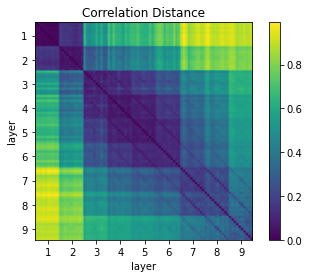

In [12]:
import matplotlib.pyplot as plt
correlations = np.load('all_cnn_c_correlations.npy')
correlations_distance = 1 - correlations
plt.title('Correlation Distance')
plt.xlabel('layer')
plt.xticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85],
           labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.yticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85],
           labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.ylabel('layer')
plt.imshow(correlations_distance)
plt.colorbar()

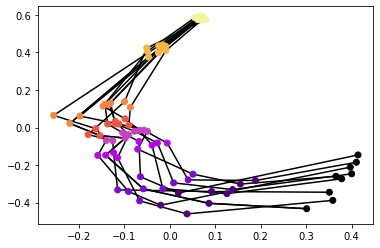

In [28]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2, dissimilarity='precomputed')
X_transformed = embedding.fit_transform(correlations_distance)
colors = ['#f5f59d', '#f5b642', '#f58742', '#f55442', '#c940c5',
          '#b407ed', '#7d09d6', '#50017a', '#000000']
plt.plot(X_transformed[::10, 0], X_transformed[::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[1::10, 0], X_transformed[1::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[2::10, 0], X_transformed[2::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[3::10, 0], X_transformed[3::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[4::10, 0], X_transformed[4::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[5::10, 0], X_transformed[5::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[6::10, 0], X_transformed[6::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[7::10, 0], X_transformed[7::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[8::10, 0], X_transformed[8::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[::10, 0], X_transformed[::10, 1], linestyle='-', color='black', zorder=1)

plt.scatter(X_transformed[::10, 0], X_transformed[::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[1::10, 0], X_transformed[1::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[2::10, 0], X_transformed[2::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[3::10, 0], X_transformed[3::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[4::10, 0], X_transformed[4::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[5::10, 0], X_transformed[5::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[6::10, 0], X_transformed[6::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[7::10, 0], X_transformed[7::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[8::10, 0], X_transformed[8::10, 1], marker='o', color=colors, zorder=2)


In [31]:
'''
SVCCA Pt. 1: Get flattened representations by avg pooling
'''

# For SVCCA, 1. prep data by avg pooling, 2. find threshold for each layer of each network
# 3. SVCCA each network with each other network, plot into graph


# Helper function to find threshold for each layer            
def search_threshold(acts):
    print('Getting threshold...')
    target = 0.99
    start = 0
    end = acts.shape[0]
    ans = -1
    while start <= end:
        mid = (start + end) // 2
        # Move to right side if target is 
        # greater. 
        s = np.linalg.svd(acts - np.mean(acts, axis=1, keepdims=True), full_matrices=False)[1]
        # Note: normally comparing floating points is a bad bad but the precision we need is low enough
        if (np.sum(s[:mid])/np.sum(s) <= target): 
            start = mid + 1;
        # Move left side. 
        else: 
            ans = mid; 
            end = mid - 1;
    # Prevent silent failure
    if ans == -1:
        raise
    print('Sanity check, achieved', np.sum(s[:ans])/np.sum(s), 'variance with', ans, 'neurons')
    return ans

num_images = len(x_predict) # 1000
num_networks = 10
num_layers = 9
rep_list = [[], [], [], [], [], [], [], [], []]
thresholds = np.empty((num_layers * num_networks))

# Loop through network instances
index = 0
for i in [200, 202, 203, 206, 207, 302, 303, 304, 305, 306]:
    print('Working on model', str(i))
    K.clear_session()
    full_model = load_model('../outputs/models/primary/instance_' + str(i) + '.h5')
    inp = full_model.input
    # Loop through layers
    for j in range(num_layers):
        print('Layer', str(j))
        out = full_model.layers[j].output
        temp_model = Model(inputs=inp, outputs=out)
        # Predict on x_predict
        print('Getting representation...')
        representations = temp_model.predict(x_predict)
        print('Old shape:', representations.shape)
        # Average pool along spacial dimensions, transpose to fit shape (imgs, neurons)
        if (len(representations.shape) > 2):
            avg = np.mean(representations, axis=(1,2)).T
            print('Avg shape:', avg.shape)
        else:
            avg = representations.T
            print('No need to flatten')
        rep_list[j].append(avg)
        thresholds[num_networks * j + index] = search_threshold(avg)
    index += 1
        
    '''
SVCCA Pt. 2: Run SVCCA on every pairing of flattened representations (90 total) and save results
'''

# Helper Function for svcca
def svcca(acts1, acts2, threshold1, threshold2):
    print('Running SVCCA...')

    # Mean subtract activations
    cacts1 = acts1 - np.mean(acts1, axis=1, keepdims=True)
    cacts2 = acts2 - np.mean(acts2, axis=1, keepdims=True)

    # Perform SVD
    U1, s1, V1 = np.linalg.svd(cacts1, full_matrices=False)
    U2, s2, V2 = np.linalg.svd(cacts2, full_matrices=False)
    svacts1 = np.dot(s1[:threshold1]*np.eye(threshold1), V1[:threshold1])
    svacts2 = np.dot(s2[:threshold2]*np.eye(threshold2), V2[:threshold2])
    print('acts1 shape:', svacts1.shape)
    print('acts2 shape:', svacts2.shape)
    svcca_results = cca_core.get_cca_similarity(svacts1, svacts2, epsilon=1e-10, verbose=False)['cca_coef1']
    return np.mean(svcca_results)
     
print('Done preprocessing representations and thresholds, now CCA')
cca_correlations = np.empty((num_layers * num_networks, num_layers * num_networks))
for i in range(cca_correlations.shape[0]):
    for j in range(cca_correlations.shape[1]):
        print('Correlation', str(i), ',', str(j))
        
        layer_i = i // num_networks
        network_i = i % num_networks
        layer_j = j // num_networks
        network_j = j % num_networks
        acts1 = rep_list[layer_i][network_i]
        acts2 = rep_list[layer_j][network_j]
        
        thresh1 = int(thresholds[i])
        thresh2 = int(thresholds[j])
        
        # Do svcca
        print('Thresholds:', str(thresh1), str(thresh2))
        cca_correlations[i, j] = svcca(acts1, acts2, thresh1, thresh2)

np.save('cca_correlations.npy', cca_correlations)
print('Done!')

Working on model 200
Layer 0
Getting representation...
Old shape: (1000, 32, 32, 96)
Avg shape: (96, 1000)
Getting threshold...
Sanity check, achieved 0.99025494 variance with 87 neurons
Layer 1
Getting representation...
Old shape: (1000, 32, 32, 96)
Avg shape: (96, 1000)
Getting threshold...
Sanity check, achieved 0.99007905 variance with 84 neurons
Layer 2
Getting representation...
Old shape: (1000, 16, 16, 96)
Avg shape: (96, 1000)
Getting threshold...
Sanity check, achieved 0.99021083 variance with 83 neurons
Layer 3
Getting representation...
Old shape: (1000, 16, 16, 192)
Avg shape: (192, 1000)
Getting threshold...
Sanity check, achieved 0.9905665 variance with 176 neurons
Layer 4
Getting representation...
Old shape: (1000, 16, 16, 192)
Avg shape: (192, 1000)
Getting threshold...
Sanity check, achieved 0.9907742 variance with 181 neurons
Layer 5
Getting representation...
Old shape: (1000, 8, 8, 192)
Avg shape: (192, 1000)
Getting threshold...
Sanity check, achieved 0.991039 varian

Old shape: (1000, 16, 16, 192)
Avg shape: (192, 1000)
Getting threshold...
Sanity check, achieved 0.99009705 variance with 180 neurons
Layer 5
Getting representation...
Old shape: (1000, 8, 8, 192)
Avg shape: (192, 1000)
Getting threshold...
Sanity check, achieved 0.9910778 variance with 185 neurons
Layer 6
Getting representation...
Old shape: (1000, 6, 6, 192)
Avg shape: (192, 1000)
Getting threshold...
Sanity check, achieved 0.9905885 variance with 185 neurons
Layer 7
Getting representation...
Old shape: (1000, 6, 6, 192)
Avg shape: (192, 1000)
Getting threshold...
Sanity check, achieved 0.99013233 variance with 184 neurons
Layer 8
Getting representation...
Old shape: (1000, 6, 6, 10)
Avg shape: (10, 1000)
Getting threshold...
Sanity check, achieved 1.0 variance with 10 neurons
Working on model 303
Layer 0
Getting representation...
Old shape: (1000, 32, 32, 96)
Avg shape: (96, 1000)
Getting threshold...
Sanity check, achieved 0.99028075 variance with 87 neurons
Layer 1
Getting repres

Correlation 0 , 13
Thresholds: 87 85
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (85, 1000)
Correlation 0 , 14
Thresholds: 87 86
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (86, 1000)
Correlation 0 , 15
Thresholds: 87 86
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (86, 1000)
Correlation 0 , 16
Thresholds: 87 84
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (84, 1000)
Correlation 0 , 17
Thresholds: 87 86
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (86, 1000)
Correlation 0 , 18
Thresholds: 87 85
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (85, 1000)
Correlation 0 , 19
Thresholds: 87 85
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (85, 1000)
Correlation 0 , 20
Thresholds: 87 83
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (83, 1000)
Correlation 0 , 21
Thresholds: 87 85
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (85, 1000)
Correlation 0 , 22
Thresholds: 87 85
Running SVCCA...
acts1 shape: (87, 1000)
acts

acts1 shape: (87, 1000)
acts2 shape: (87, 1000)
Correlation 1 , 4
Thresholds: 87 87
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (87, 1000)
Correlation 1 , 5
Thresholds: 87 87
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (87, 1000)
Correlation 1 , 6
Thresholds: 87 87
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (87, 1000)
Correlation 1 , 7
Thresholds: 87 87
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (87, 1000)
Correlation 1 , 8
Thresholds: 87 87
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (87, 1000)
Correlation 1 , 9
Thresholds: 87 87
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (87, 1000)
Correlation 1 , 10
Thresholds: 87 84
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (84, 1000)
Correlation 1 , 11
Thresholds: 87 85
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (85, 1000)
Correlation 1 , 12
Thresholds: 87 85
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (85, 1000)
Correlation 1 , 13
Thresholds: 87 85
Run

acts1 shape: (87, 1000)
acts2 shape: (10, 1000)
Correlation 1 , 85
Thresholds: 87 10
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (10, 1000)
Correlation 1 , 86
Thresholds: 87 10
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (10, 1000)
Correlation 1 , 87
Thresholds: 87 10
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (10, 1000)
Correlation 1 , 88
Thresholds: 87 10
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (10, 1000)
Correlation 1 , 89
Thresholds: 87 10
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (10, 1000)
Correlation 2 , 0
Thresholds: 87 87
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (87, 1000)
Correlation 2 , 1
Thresholds: 87 87
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (87, 1000)
Correlation 2 , 2
Thresholds: 87 87
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (87, 1000)
Correlation 2 , 3
Thresholds: 87 87
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (87, 1000)
Correlation 2 , 4
Thresholds: 87 87
Ru

acts1 shape: (87, 1000)
acts2 shape: (185, 1000)
Correlation 2 , 75
Thresholds: 87 184
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (184, 1000)
Correlation 2 , 76
Thresholds: 87 185
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (185, 1000)
Correlation 2 , 77
Thresholds: 87 184
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (184, 1000)
Correlation 2 , 78
Thresholds: 87 184
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (184, 1000)
Correlation 2 , 79
Thresholds: 87 184
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (184, 1000)
Correlation 2 , 80
Thresholds: 87 10
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (10, 1000)
Correlation 2 , 81
Thresholds: 87 10
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (10, 1000)
Correlation 2 , 82
Thresholds: 87 10
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (10, 1000)
Correlation 2 , 83
Thresholds: 87 10
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (10, 1000)
Correlation 2 , 84
Thre

acts1 shape: (87, 1000)
acts2 shape: (186, 1000)
Correlation 3 , 65
Thresholds: 87 185
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (185, 1000)
Correlation 3 , 66
Thresholds: 87 185
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (185, 1000)
Correlation 3 , 67
Thresholds: 87 185
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (185, 1000)
Correlation 3 , 68
Thresholds: 87 185
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (185, 1000)
Correlation 3 , 69
Thresholds: 87 184
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (184, 1000)
Correlation 3 , 70
Thresholds: 87 185
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (185, 1000)
Correlation 3 , 71
Thresholds: 87 183
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (183, 1000)
Correlation 3 , 72
Thresholds: 87 185
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (185, 1000)
Correlation 3 , 73
Thresholds: 87 186
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (186, 1000)
Correlation 3 ,

acts1 shape: (87, 1000)
acts2 shape: (185, 1000)
Correlation 4 , 55
Thresholds: 87 185
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (185, 1000)
Correlation 4 , 56
Thresholds: 87 185
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (185, 1000)
Correlation 4 , 57
Thresholds: 87 185
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (185, 1000)
Correlation 4 , 58
Thresholds: 87 185
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (185, 1000)
Correlation 4 , 59
Thresholds: 87 184
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (184, 1000)
Correlation 4 , 60
Thresholds: 87 186
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (186, 1000)
Correlation 4 , 61
Thresholds: 87 185
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (185, 1000)
Correlation 4 , 62
Thresholds: 87 186
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (186, 1000)
Correlation 4 , 63
Thresholds: 87 184
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (184, 1000)
Correlation 4 ,

acts1 shape: (87, 1000)
acts2 shape: (181, 1000)
Correlation 5 , 45
Thresholds: 87 180
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (180, 1000)
Correlation 5 , 46
Thresholds: 87 181
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (181, 1000)
Correlation 5 , 47
Thresholds: 87 181
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (181, 1000)
Correlation 5 , 48
Thresholds: 87 181
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (181, 1000)
Correlation 5 , 49
Thresholds: 87 179
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (179, 1000)
Correlation 5 , 50
Thresholds: 87 185
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (185, 1000)
Correlation 5 , 51
Thresholds: 87 186
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (186, 1000)
Correlation 5 , 52
Thresholds: 87 184
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (184, 1000)
Correlation 5 , 53
Thresholds: 87 183
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (183, 1000)
Correlation 5 ,

Correlation 6 , 35
Thresholds: 87 178
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (178, 1000)
Correlation 6 , 36
Thresholds: 87 176
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (176, 1000)
Correlation 6 , 37
Thresholds: 87 177
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (177, 1000)
Correlation 6 , 38
Thresholds: 87 177
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (177, 1000)
Correlation 6 , 39
Thresholds: 87 176
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (176, 1000)
Correlation 6 , 40
Thresholds: 87 181
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (181, 1000)
Correlation 6 , 41
Thresholds: 87 182
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (182, 1000)
Correlation 6 , 42
Thresholds: 87 181
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (181, 1000)
Correlation 6 , 43
Thresholds: 87 177
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (177, 1000)
Correlation 6 , 44
Thresholds: 87 181
Running SVCCA...
acts1 sha

acts1 shape: (87, 1000)
acts2 shape: (86, 1000)
Correlation 7 , 26
Thresholds: 87 86
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (86, 1000)
Correlation 7 , 27
Thresholds: 87 85
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (85, 1000)
Correlation 7 , 28
Thresholds: 87 86
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (86, 1000)
Correlation 7 , 29
Thresholds: 87 87
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (87, 1000)
Correlation 7 , 30
Thresholds: 87 176
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (176, 1000)
Correlation 7 , 31
Thresholds: 87 177
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (177, 1000)
Correlation 7 , 32
Thresholds: 87 176
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (176, 1000)
Correlation 7 , 33
Thresholds: 87 177
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (177, 1000)
Correlation 7 , 34
Thresholds: 87 175
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (175, 1000)
Correlation 7 , 35
Thres

acts1 shape: (87, 1000)
acts2 shape: (86, 1000)
Correlation 8 , 16
Thresholds: 87 84
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (84, 1000)
Correlation 8 , 17
Thresholds: 87 86
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (86, 1000)
Correlation 8 , 18
Thresholds: 87 85
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (85, 1000)
Correlation 8 , 19
Thresholds: 87 85
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (85, 1000)
Correlation 8 , 20
Thresholds: 87 83
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (83, 1000)
Correlation 8 , 21
Thresholds: 87 85
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (85, 1000)
Correlation 8 , 22
Thresholds: 87 85
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (85, 1000)
Correlation 8 , 23
Thresholds: 87 86
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (86, 1000)
Correlation 8 , 24
Thresholds: 87 85
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (85, 1000)
Correlation 8 , 25
Thresholds: 87 

Correlation 9 , 6
Thresholds: 87 87
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (87, 1000)
Correlation 9 , 7
Thresholds: 87 87
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (87, 1000)
Correlation 9 , 8
Thresholds: 87 87
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (87, 1000)
Correlation 9 , 9
Thresholds: 87 87
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (87, 1000)
Correlation 9 , 10
Thresholds: 87 84
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (84, 1000)
Correlation 9 , 11
Thresholds: 87 85
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (85, 1000)
Correlation 9 , 12
Thresholds: 87 85
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (85, 1000)
Correlation 9 , 13
Thresholds: 87 85
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (85, 1000)
Correlation 9 , 14
Thresholds: 87 86
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (86, 1000)
Correlation 9 , 15
Thresholds: 87 86
Running SVCCA...
acts1 shape: (87, 1000)
acts2 sh

acts1 shape: (87, 1000)
acts2 shape: (10, 1000)
Correlation 9 , 87
Thresholds: 87 10
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (10, 1000)
Correlation 9 , 88
Thresholds: 87 10
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (10, 1000)
Correlation 9 , 89
Thresholds: 87 10
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (10, 1000)
Correlation 10 , 0
Thresholds: 84 87
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (87, 1000)
Correlation 10 , 1
Thresholds: 84 87
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (87, 1000)
Correlation 10 , 2
Thresholds: 84 87
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (87, 1000)
Correlation 10 , 3
Thresholds: 84 87
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (87, 1000)
Correlation 10 , 4
Thresholds: 84 87
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (87, 1000)
Correlation 10 , 5
Thresholds: 84 87
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (87, 1000)
Correlation 10 , 6
Thresholds: 84 

acts1 shape: (84, 1000)
acts2 shape: (184, 1000)
Correlation 10 , 76
Thresholds: 84 185
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (185, 1000)
Correlation 10 , 77
Thresholds: 84 184
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (184, 1000)
Correlation 10 , 78
Thresholds: 84 184
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (184, 1000)
Correlation 10 , 79
Thresholds: 84 184
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (184, 1000)
Correlation 10 , 80
Thresholds: 84 10
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (10, 1000)
Correlation 10 , 81
Thresholds: 84 10
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (10, 1000)
Correlation 10 , 82
Thresholds: 84 10
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (10, 1000)
Correlation 10 , 83
Thresholds: 84 10
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (10, 1000)
Correlation 10 , 84
Thresholds: 84 10
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (10, 1000)
Correlation 10 ,

Correlation 11 , 65
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 11 , 66
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 11 , 67
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 11 , 68
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 11 , 69
Thresholds: 85 184
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (184, 1000)
Correlation 11 , 70
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 11 , 71
Thresholds: 85 183
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (183, 1000)
Correlation 11 , 72
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 11 , 73
Thresholds: 85 186
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (186, 1000)
Correlation 11 , 74
Thresholds: 85 185
Running SVCCA...

acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 12 , 55
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 12 , 56
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 12 , 57
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 12 , 58
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 12 , 59
Thresholds: 85 184
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (184, 1000)
Correlation 12 , 60
Thresholds: 85 186
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (186, 1000)
Correlation 12 , 61
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 12 , 62
Thresholds: 85 186
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (186, 1000)
Correlation 12 , 63
Thresholds: 85 184
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (184, 1000)
Correl

acts1 shape: (85, 1000)
acts2 shape: (177, 1000)
Correlation 13 , 44
Thresholds: 85 181
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (181, 1000)
Correlation 13 , 45
Thresholds: 85 180
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (180, 1000)
Correlation 13 , 46
Thresholds: 85 181
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (181, 1000)
Correlation 13 , 47
Thresholds: 85 181
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (181, 1000)
Correlation 13 , 48
Thresholds: 85 181
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (181, 1000)
Correlation 13 , 49
Thresholds: 85 179
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (179, 1000)
Correlation 13 , 50
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 13 , 51
Thresholds: 85 186
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (186, 1000)
Correlation 13 , 52
Thresholds: 85 184
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (184, 1000)
Correl

acts1 shape: (86, 1000)
acts2 shape: (176, 1000)
Correlation 14 , 33
Thresholds: 86 177
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (177, 1000)
Correlation 14 , 34
Thresholds: 86 175
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (175, 1000)
Correlation 14 , 35
Thresholds: 86 178
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (178, 1000)
Correlation 14 , 36
Thresholds: 86 176
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (176, 1000)
Correlation 14 , 37
Thresholds: 86 177
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (177, 1000)
Correlation 14 , 38
Thresholds: 86 177
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (177, 1000)
Correlation 14 , 39
Thresholds: 86 176
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (176, 1000)
Correlation 14 , 40
Thresholds: 86 181
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (181, 1000)
Correlation 14 , 41
Thresholds: 86 182
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (182, 1000)
Correl

Correlation 15 , 22
Thresholds: 86 85
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (85, 1000)
Correlation 15 , 23
Thresholds: 86 86
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (86, 1000)
Correlation 15 , 24
Thresholds: 86 85
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (85, 1000)
Correlation 15 , 25
Thresholds: 86 86
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (86, 1000)
Correlation 15 , 26
Thresholds: 86 86
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (86, 1000)
Correlation 15 , 27
Thresholds: 86 85
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (85, 1000)
Correlation 15 , 28
Thresholds: 86 86
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (86, 1000)
Correlation 15 , 29
Thresholds: 86 87
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (87, 1000)
Correlation 15 , 30
Thresholds: 86 176
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (176, 1000)
Correlation 15 , 31
Thresholds: 86 177
Running SVCCA...
acts1 shape: (8

acts1 shape: (84, 1000)
acts2 shape: (85, 1000)
Correlation 16 , 12
Thresholds: 84 85
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (85, 1000)
Correlation 16 , 13
Thresholds: 84 85
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (85, 1000)
Correlation 16 , 14
Thresholds: 84 86
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (86, 1000)
Correlation 16 , 15
Thresholds: 84 86
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (86, 1000)
Correlation 16 , 16
Thresholds: 84 84
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (84, 1000)
Correlation 16 , 17
Thresholds: 84 86
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (86, 1000)
Correlation 16 , 18
Thresholds: 84 85
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (85, 1000)
Correlation 16 , 19
Thresholds: 84 85
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (85, 1000)
Correlation 16 , 20
Thresholds: 84 83
Running SVCCA...
acts1 shape: (84, 1000)
acts2 shape: (83, 1000)
Correlation 16 , 21
Thres

acts1 shape: (86, 1000)
acts2 shape: (87, 1000)
Correlation 17 , 1
Thresholds: 86 87
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (87, 1000)
Correlation 17 , 2
Thresholds: 86 87
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (87, 1000)
Correlation 17 , 3
Thresholds: 86 87
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (87, 1000)
Correlation 17 , 4
Thresholds: 86 87
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (87, 1000)
Correlation 17 , 5
Thresholds: 86 87
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (87, 1000)
Correlation 17 , 6
Thresholds: 86 87
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (87, 1000)
Correlation 17 , 7
Thresholds: 86 87
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (87, 1000)
Correlation 17 , 8
Thresholds: 86 87
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (87, 1000)
Correlation 17 , 9
Thresholds: 86 87
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (87, 1000)
Correlation 17 , 10
Thresholds: 86

acts1 shape: (86, 1000)
acts2 shape: (184, 1000)
Correlation 17 , 80
Thresholds: 86 10
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (10, 1000)
Correlation 17 , 81
Thresholds: 86 10
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (10, 1000)
Correlation 17 , 82
Thresholds: 86 10
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (10, 1000)
Correlation 17 , 83
Thresholds: 86 10
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (10, 1000)
Correlation 17 , 84
Thresholds: 86 10
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (10, 1000)
Correlation 17 , 85
Thresholds: 86 10
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (10, 1000)
Correlation 17 , 86
Thresholds: 86 10
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (10, 1000)
Correlation 17 , 87
Thresholds: 86 10
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (10, 1000)
Correlation 17 , 88
Thresholds: 86 10
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (10, 1000)
Correlation 17 , 89
Thre

Correlation 18 , 69
Thresholds: 85 184
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (184, 1000)
Correlation 18 , 70
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 18 , 71
Thresholds: 85 183
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (183, 1000)
Correlation 18 , 72
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 18 , 73
Thresholds: 85 186
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (186, 1000)
Correlation 18 , 74
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 18 , 75
Thresholds: 85 184
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (184, 1000)
Correlation 18 , 76
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 18 , 77
Thresholds: 85 184
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (184, 1000)
Correlation 18 , 78
Thresholds: 85 184
Running SVCCA...

acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 19 , 59
Thresholds: 85 184
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (184, 1000)
Correlation 19 , 60
Thresholds: 85 186
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (186, 1000)
Correlation 19 , 61
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 19 , 62
Thresholds: 85 186
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (186, 1000)
Correlation 19 , 63
Thresholds: 85 184
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (184, 1000)
Correlation 19 , 64
Thresholds: 85 186
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (186, 1000)
Correlation 19 , 65
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 19 , 66
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 19 , 67
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correl

acts1 shape: (83, 1000)
acts2 shape: (181, 1000)
Correlation 20 , 48
Thresholds: 83 181
Running SVCCA...
acts1 shape: (83, 1000)
acts2 shape: (181, 1000)
Correlation 20 , 49
Thresholds: 83 179
Running SVCCA...
acts1 shape: (83, 1000)
acts2 shape: (179, 1000)
Correlation 20 , 50
Thresholds: 83 185
Running SVCCA...
acts1 shape: (83, 1000)
acts2 shape: (185, 1000)
Correlation 20 , 51
Thresholds: 83 186
Running SVCCA...
acts1 shape: (83, 1000)
acts2 shape: (186, 1000)
Correlation 20 , 52
Thresholds: 83 184
Running SVCCA...
acts1 shape: (83, 1000)
acts2 shape: (184, 1000)
Correlation 20 , 53
Thresholds: 83 183
Running SVCCA...
acts1 shape: (83, 1000)
acts2 shape: (183, 1000)
Correlation 20 , 54
Thresholds: 83 185
Running SVCCA...
acts1 shape: (83, 1000)
acts2 shape: (185, 1000)
Correlation 20 , 55
Thresholds: 83 185
Running SVCCA...
acts1 shape: (83, 1000)
acts2 shape: (185, 1000)
Correlation 20 , 56
Thresholds: 83 185
Running SVCCA...
acts1 shape: (83, 1000)
acts2 shape: (185, 1000)
Correl

Correlation 21 , 37
Thresholds: 85 177
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (177, 1000)
Correlation 21 , 38
Thresholds: 85 177
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (177, 1000)
Correlation 21 , 39
Thresholds: 85 176
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (176, 1000)
Correlation 21 , 40
Thresholds: 85 181
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (181, 1000)
Correlation 21 , 41
Thresholds: 85 182
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (182, 1000)
Correlation 21 , 42
Thresholds: 85 181
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (181, 1000)
Correlation 21 , 43
Thresholds: 85 177
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (177, 1000)
Correlation 21 , 44
Thresholds: 85 181
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (181, 1000)
Correlation 21 , 45
Thresholds: 85 180
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (180, 1000)
Correlation 21 , 46
Thresholds: 85 181
Running SVCCA...

acts1 shape: (85, 1000)
acts2 shape: (86, 1000)
Correlation 22 , 27
Thresholds: 85 85
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (85, 1000)
Correlation 22 , 28
Thresholds: 85 86
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (86, 1000)
Correlation 22 , 29
Thresholds: 85 87
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (87, 1000)
Correlation 22 , 30
Thresholds: 85 176
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (176, 1000)
Correlation 22 , 31
Thresholds: 85 177
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (177, 1000)
Correlation 22 , 32
Thresholds: 85 176
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (176, 1000)
Correlation 22 , 33
Thresholds: 85 177
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (177, 1000)
Correlation 22 , 34
Thresholds: 85 175
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (175, 1000)
Correlation 22 , 35
Thresholds: 85 178
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (178, 1000)
Correlation 2

acts1 shape: (86, 1000)
acts2 shape: (84, 1000)
Correlation 23 , 17
Thresholds: 86 86
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (86, 1000)
Correlation 23 , 18
Thresholds: 86 85
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (85, 1000)
Correlation 23 , 19
Thresholds: 86 85
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (85, 1000)
Correlation 23 , 20
Thresholds: 86 83
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (83, 1000)
Correlation 23 , 21
Thresholds: 86 85
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (85, 1000)
Correlation 23 , 22
Thresholds: 86 85
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (85, 1000)
Correlation 23 , 23
Thresholds: 86 86
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (86, 1000)
Correlation 23 , 24
Thresholds: 86 85
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (85, 1000)
Correlation 23 , 25
Thresholds: 86 86
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (86, 1000)
Correlation 23 , 26
Thres

acts1 shape: (85, 1000)
acts2 shape: (87, 1000)
Correlation 24 , 6
Thresholds: 85 87
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (87, 1000)
Correlation 24 , 7
Thresholds: 85 87
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (87, 1000)
Correlation 24 , 8
Thresholds: 85 87
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (87, 1000)
Correlation 24 , 9
Thresholds: 85 87
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (87, 1000)
Correlation 24 , 10
Thresholds: 85 84
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (84, 1000)
Correlation 24 , 11
Thresholds: 85 85
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (85, 1000)
Correlation 24 , 12
Thresholds: 85 85
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (85, 1000)
Correlation 24 , 13
Thresholds: 85 85
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (85, 1000)
Correlation 24 , 14
Thresholds: 85 86
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (86, 1000)
Correlation 24 , 15
Threshold

acts1 shape: (85, 1000)
acts2 shape: (10, 1000)
Correlation 24 , 87
Thresholds: 85 10
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (10, 1000)
Correlation 24 , 88
Thresholds: 85 10
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (10, 1000)
Correlation 24 , 89
Thresholds: 85 10
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (10, 1000)
Correlation 25 , 0
Thresholds: 86 87
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (87, 1000)
Correlation 25 , 1
Thresholds: 86 87
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (87, 1000)
Correlation 25 , 2
Thresholds: 86 87
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (87, 1000)
Correlation 25 , 3
Thresholds: 86 87
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (87, 1000)
Correlation 25 , 4
Thresholds: 86 87
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (87, 1000)
Correlation 25 , 5
Thresholds: 86 87
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (87, 1000)
Correlation 25 , 6
Thresholds: 

acts1 shape: (86, 1000)
acts2 shape: (184, 1000)
Correlation 25 , 76
Thresholds: 86 185
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (185, 1000)
Correlation 25 , 77
Thresholds: 86 184
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (184, 1000)
Correlation 25 , 78
Thresholds: 86 184
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (184, 1000)
Correlation 25 , 79
Thresholds: 86 184
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (184, 1000)
Correlation 25 , 80
Thresholds: 86 10
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (10, 1000)
Correlation 25 , 81
Thresholds: 86 10
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (10, 1000)
Correlation 25 , 82
Thresholds: 86 10
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (10, 1000)
Correlation 25 , 83
Thresholds: 86 10
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (10, 1000)
Correlation 25 , 84
Thresholds: 86 10
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (10, 1000)
Correlation 25 ,

acts1 shape: (86, 1000)
acts2 shape: (186, 1000)
Correlation 26 , 65
Thresholds: 86 185
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (185, 1000)
Correlation 26 , 66
Thresholds: 86 185
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (185, 1000)
Correlation 26 , 67
Thresholds: 86 185
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (185, 1000)
Correlation 26 , 68
Thresholds: 86 185
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (185, 1000)
Correlation 26 , 69
Thresholds: 86 184
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (184, 1000)
Correlation 26 , 70
Thresholds: 86 185
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (185, 1000)
Correlation 26 , 71
Thresholds: 86 183
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (183, 1000)
Correlation 26 , 72
Thresholds: 86 185
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (185, 1000)
Correlation 26 , 73
Thresholds: 86 186
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (186, 1000)
Correl

acts1 shape: (85, 1000)
acts2 shape: (183, 1000)
Correlation 27 , 54
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 27 , 55
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 27 , 56
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 27 , 57
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 27 , 58
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 27 , 59
Thresholds: 85 184
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (184, 1000)
Correlation 27 , 60
Thresholds: 85 186
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (186, 1000)
Correlation 27 , 61
Thresholds: 85 185
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (185, 1000)
Correlation 27 , 62
Thresholds: 85 186
Running SVCCA...
acts1 shape: (85, 1000)
acts2 shape: (186, 1000)
Correl

acts1 shape: (86, 1000)
acts2 shape: (181, 1000)
Correlation 28 , 43
Thresholds: 86 177
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (177, 1000)
Correlation 28 , 44
Thresholds: 86 181
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (181, 1000)
Correlation 28 , 45
Thresholds: 86 180
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (180, 1000)
Correlation 28 , 46
Thresholds: 86 181
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (181, 1000)
Correlation 28 , 47
Thresholds: 86 181
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (181, 1000)
Correlation 28 , 48
Thresholds: 86 181
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (181, 1000)
Correlation 28 , 49
Thresholds: 86 179
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (179, 1000)
Correlation 28 , 50
Thresholds: 86 185
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (185, 1000)
Correlation 28 , 51
Thresholds: 86 186
Running SVCCA...
acts1 shape: (86, 1000)
acts2 shape: (186, 1000)
Correl

Correlation 29 , 32
Thresholds: 87 176
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (176, 1000)
Correlation 29 , 33
Thresholds: 87 177
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (177, 1000)
Correlation 29 , 34
Thresholds: 87 175
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (175, 1000)
Correlation 29 , 35
Thresholds: 87 178
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (178, 1000)
Correlation 29 , 36
Thresholds: 87 176
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (176, 1000)
Correlation 29 , 37
Thresholds: 87 177
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (177, 1000)
Correlation 29 , 38
Thresholds: 87 177
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (177, 1000)
Correlation 29 , 39
Thresholds: 87 176
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (176, 1000)
Correlation 29 , 40
Thresholds: 87 181
Running SVCCA...
acts1 shape: (87, 1000)
acts2 shape: (181, 1000)
Correlation 29 , 41
Thresholds: 87 182
Running SVCCA...

Correlation 30 , 21
Thresholds: 176 85
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (85, 1000)
Correlation 30 , 22
Thresholds: 176 85
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (85, 1000)
Correlation 30 , 23
Thresholds: 176 86
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (86, 1000)
Correlation 30 , 24
Thresholds: 176 85
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (85, 1000)
Correlation 30 , 25
Thresholds: 176 86
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (86, 1000)
Correlation 30 , 26
Thresholds: 176 86
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (86, 1000)
Correlation 30 , 27
Thresholds: 176 85
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (85, 1000)
Correlation 30 , 28
Thresholds: 176 86
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (86, 1000)
Correlation 30 , 29
Thresholds: 176 87
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (87, 1000)
Correlation 30 , 30
Thresholds: 176 176
Running SVCCA..

Correlation 31 , 9
Thresholds: 177 87
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (87, 1000)
Correlation 31 , 10
Thresholds: 177 84
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (84, 1000)
Correlation 31 , 11
Thresholds: 177 85
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (85, 1000)
Correlation 31 , 12
Thresholds: 177 85
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (85, 1000)
Correlation 31 , 13
Thresholds: 177 85
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (85, 1000)
Correlation 31 , 14
Thresholds: 177 86
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (86, 1000)
Correlation 31 , 15
Thresholds: 177 86
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (86, 1000)
Correlation 31 , 16
Thresholds: 177 84
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (84, 1000)
Correlation 31 , 17
Thresholds: 177 86
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (86, 1000)
Correlation 31 , 18
Thresholds: 177 85
Running SVCCA...


acts1 shape: (177, 1000)
acts2 shape: (10, 1000)
Correlation 31 , 87
Thresholds: 177 10
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (10, 1000)
Correlation 31 , 88
Thresholds: 177 10
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (10, 1000)
Correlation 31 , 89
Thresholds: 177 10
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (10, 1000)
Correlation 32 , 0
Thresholds: 176 87
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (87, 1000)
Correlation 32 , 1
Thresholds: 176 87
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (87, 1000)
Correlation 32 , 2
Thresholds: 176 87
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (87, 1000)
Correlation 32 , 3
Thresholds: 176 87
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (87, 1000)
Correlation 32 , 4
Thresholds: 176 87
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (87, 1000)
Correlation 32 , 5
Thresholds: 176 87
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (87, 1000)
Correlation 

acts1 shape: (176, 1000)
acts2 shape: (185, 1000)
Correlation 32 , 75
Thresholds: 176 184
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (184, 1000)
Correlation 32 , 76
Thresholds: 176 185
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (185, 1000)
Correlation 32 , 77
Thresholds: 176 184
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (184, 1000)
Correlation 32 , 78
Thresholds: 176 184
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (184, 1000)
Correlation 32 , 79
Thresholds: 176 184
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (184, 1000)
Correlation 32 , 80
Thresholds: 176 10
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (10, 1000)
Correlation 32 , 81
Thresholds: 176 10
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (10, 1000)
Correlation 32 , 82
Thresholds: 176 10
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (10, 1000)
Correlation 32 , 83
Thresholds: 176 10
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (10, 1

acts1 shape: (177, 1000)
acts2 shape: (186, 1000)
Correlation 33 , 63
Thresholds: 177 184
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (184, 1000)
Correlation 33 , 64
Thresholds: 177 186
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (186, 1000)
Correlation 33 , 65
Thresholds: 177 185
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (185, 1000)
Correlation 33 , 66
Thresholds: 177 185
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (185, 1000)
Correlation 33 , 67
Thresholds: 177 185
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (185, 1000)
Correlation 33 , 68
Thresholds: 177 185
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (185, 1000)
Correlation 33 , 69
Thresholds: 177 184
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (184, 1000)
Correlation 33 , 70
Thresholds: 177 185
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (185, 1000)
Correlation 33 , 71
Thresholds: 177 183
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape:

Correlation 34 , 50
Thresholds: 175 185
Running SVCCA...
acts1 shape: (175, 1000)
acts2 shape: (185, 1000)
Correlation 34 , 51
Thresholds: 175 186
Running SVCCA...
acts1 shape: (175, 1000)
acts2 shape: (186, 1000)
Correlation 34 , 52
Thresholds: 175 184
Running SVCCA...
acts1 shape: (175, 1000)
acts2 shape: (184, 1000)
Correlation 34 , 53
Thresholds: 175 183
Running SVCCA...
acts1 shape: (175, 1000)
acts2 shape: (183, 1000)
Correlation 34 , 54
Thresholds: 175 185
Running SVCCA...
acts1 shape: (175, 1000)
acts2 shape: (185, 1000)
Correlation 34 , 55
Thresholds: 175 185
Running SVCCA...
acts1 shape: (175, 1000)
acts2 shape: (185, 1000)
Correlation 34 , 56
Thresholds: 175 185
Running SVCCA...
acts1 shape: (175, 1000)
acts2 shape: (185, 1000)
Correlation 34 , 57
Thresholds: 175 185
Running SVCCA...
acts1 shape: (175, 1000)
acts2 shape: (185, 1000)
Correlation 34 , 58
Thresholds: 175 185
Running SVCCA...
acts1 shape: (175, 1000)
acts2 shape: (185, 1000)
Correlation 34 , 59
Thresholds: 175 1

acts1 shape: (178, 1000)
acts2 shape: (177, 1000)
Correlation 35 , 38
Thresholds: 178 177
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (177, 1000)
Correlation 35 , 39
Thresholds: 178 176
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (176, 1000)
Correlation 35 , 40
Thresholds: 178 181
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (181, 1000)
Correlation 35 , 41
Thresholds: 178 182
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (182, 1000)
Correlation 35 , 42
Thresholds: 178 181
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (181, 1000)
Correlation 35 , 43
Thresholds: 178 177
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (177, 1000)
Correlation 35 , 44
Thresholds: 178 181
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (181, 1000)
Correlation 35 , 45
Thresholds: 178 180
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (180, 1000)
Correlation 35 , 46
Thresholds: 178 181
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape:

Correlation 36 , 25
Thresholds: 176 86
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (86, 1000)
Correlation 36 , 26
Thresholds: 176 86
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (86, 1000)
Correlation 36 , 27
Thresholds: 176 85
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (85, 1000)
Correlation 36 , 28
Thresholds: 176 86
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (86, 1000)
Correlation 36 , 29
Thresholds: 176 87
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (87, 1000)
Correlation 36 , 30
Thresholds: 176 176
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (176, 1000)
Correlation 36 , 31
Thresholds: 176 177
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (177, 1000)
Correlation 36 , 32
Thresholds: 176 176
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (176, 1000)
Correlation 36 , 33
Thresholds: 176 177
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (177, 1000)
Correlation 36 , 34
Thresholds: 176 175
Running

Correlation 37 , 13
Thresholds: 177 85
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (85, 1000)
Correlation 37 , 14
Thresholds: 177 86
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (86, 1000)
Correlation 37 , 15
Thresholds: 177 86
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (86, 1000)
Correlation 37 , 16
Thresholds: 177 84
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (84, 1000)
Correlation 37 , 17
Thresholds: 177 86
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (86, 1000)
Correlation 37 , 18
Thresholds: 177 85
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (85, 1000)
Correlation 37 , 19
Thresholds: 177 85
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (85, 1000)
Correlation 37 , 20
Thresholds: 177 83
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (83, 1000)
Correlation 37 , 21
Thresholds: 177 85
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (85, 1000)
Correlation 37 , 22
Thresholds: 177 85
Running SVCCA...

acts1 shape: (177, 1000)
acts2 shape: (87, 1000)
Correlation 38 , 1
Thresholds: 177 87
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (87, 1000)
Correlation 38 , 2
Thresholds: 177 87
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (87, 1000)
Correlation 38 , 3
Thresholds: 177 87
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (87, 1000)
Correlation 38 , 4
Thresholds: 177 87
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (87, 1000)
Correlation 38 , 5
Thresholds: 177 87
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (87, 1000)
Correlation 38 , 6
Thresholds: 177 87
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (87, 1000)
Correlation 38 , 7
Thresholds: 177 87
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (87, 1000)
Correlation 38 , 8
Thresholds: 177 87
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (87, 1000)
Correlation 38 , 9
Thresholds: 177 87
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (87, 1000)
Correlation 38 

acts1 shape: (177, 1000)
acts2 shape: (184, 1000)
Correlation 38 , 79
Thresholds: 177 184
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (184, 1000)
Correlation 38 , 80
Thresholds: 177 10
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (10, 1000)
Correlation 38 , 81
Thresholds: 177 10
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (10, 1000)
Correlation 38 , 82
Thresholds: 177 10
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (10, 1000)
Correlation 38 , 83
Thresholds: 177 10
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (10, 1000)
Correlation 38 , 84
Thresholds: 177 10
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (10, 1000)
Correlation 38 , 85
Thresholds: 177 10
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (10, 1000)
Correlation 38 , 86
Thresholds: 177 10
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (10, 1000)
Correlation 38 , 87
Thresholds: 177 10
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (10, 1000)
Cor

acts1 shape: (176, 1000)
acts2 shape: (185, 1000)
Correlation 39 , 67
Thresholds: 176 185
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (185, 1000)
Correlation 39 , 68
Thresholds: 176 185
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (185, 1000)
Correlation 39 , 69
Thresholds: 176 184
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (184, 1000)
Correlation 39 , 70
Thresholds: 176 185
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (185, 1000)
Correlation 39 , 71
Thresholds: 176 183
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (183, 1000)
Correlation 39 , 72
Thresholds: 176 185
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (185, 1000)
Correlation 39 , 73
Thresholds: 176 186
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (186, 1000)
Correlation 39 , 74
Thresholds: 176 185
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (185, 1000)
Correlation 39 , 75
Thresholds: 176 184
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape:

acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 40 , 55
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 40 , 56
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 40 , 57
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 40 , 58
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 40 , 59
Thresholds: 181 184
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (184, 1000)
Correlation 40 , 60
Thresholds: 181 186
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (186, 1000)
Correlation 40 , 61
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 40 , 62
Thresholds: 181 186
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (186, 1000)
Correlation 40 , 63
Thresholds: 181 184
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape:

acts1 shape: (182, 1000)
acts2 shape: (181, 1000)
Correlation 41 , 43
Thresholds: 182 177
Running SVCCA...
acts1 shape: (182, 1000)
acts2 shape: (177, 1000)
Correlation 41 , 44
Thresholds: 182 181
Running SVCCA...
acts1 shape: (182, 1000)
acts2 shape: (181, 1000)
Correlation 41 , 45
Thresholds: 182 180
Running SVCCA...
acts1 shape: (182, 1000)
acts2 shape: (180, 1000)
Correlation 41 , 46
Thresholds: 182 181
Running SVCCA...
acts1 shape: (182, 1000)
acts2 shape: (181, 1000)
Correlation 41 , 47
Thresholds: 182 181
Running SVCCA...
acts1 shape: (182, 1000)
acts2 shape: (181, 1000)
Correlation 41 , 48
Thresholds: 182 181
Running SVCCA...
acts1 shape: (182, 1000)
acts2 shape: (181, 1000)
Correlation 41 , 49
Thresholds: 182 179
Running SVCCA...
acts1 shape: (182, 1000)
acts2 shape: (179, 1000)
Correlation 41 , 50
Thresholds: 182 185
Running SVCCA...
acts1 shape: (182, 1000)
acts2 shape: (185, 1000)
Correlation 41 , 51
Thresholds: 182 186
Running SVCCA...
acts1 shape: (182, 1000)
acts2 shape:

acts1 shape: (181, 1000)
acts2 shape: (176, 1000)
Correlation 42 , 31
Thresholds: 181 177
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (177, 1000)
Correlation 42 , 32
Thresholds: 181 176
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (176, 1000)
Correlation 42 , 33
Thresholds: 181 177
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (177, 1000)
Correlation 42 , 34
Thresholds: 181 175
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (175, 1000)
Correlation 42 , 35
Thresholds: 181 178
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (178, 1000)
Correlation 42 , 36
Thresholds: 181 176
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (176, 1000)
Correlation 42 , 37
Thresholds: 181 177
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (177, 1000)
Correlation 42 , 38
Thresholds: 181 177
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (177, 1000)
Correlation 42 , 39
Thresholds: 181 176
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape:

acts1 shape: (177, 1000)
acts2 shape: (85, 1000)
Correlation 43 , 19
Thresholds: 177 85
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (85, 1000)
Correlation 43 , 20
Thresholds: 177 83
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (83, 1000)
Correlation 43 , 21
Thresholds: 177 85
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (85, 1000)
Correlation 43 , 22
Thresholds: 177 85
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (85, 1000)
Correlation 43 , 23
Thresholds: 177 86
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (86, 1000)
Correlation 43 , 24
Thresholds: 177 85
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (85, 1000)
Correlation 43 , 25
Thresholds: 177 86
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (86, 1000)
Correlation 43 , 26
Thresholds: 177 86
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (86, 1000)
Correlation 43 , 27
Thresholds: 177 85
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (85, 1000)
Correl

acts1 shape: (181, 1000)
acts2 shape: (87, 1000)
Correlation 44 , 7
Thresholds: 181 87
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (87, 1000)
Correlation 44 , 8
Thresholds: 181 87
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (87, 1000)
Correlation 44 , 9
Thresholds: 181 87
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (87, 1000)
Correlation 44 , 10
Thresholds: 181 84
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (84, 1000)
Correlation 44 , 11
Thresholds: 181 85
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (85, 1000)
Correlation 44 , 12
Thresholds: 181 85
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (85, 1000)
Correlation 44 , 13
Thresholds: 181 85
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (85, 1000)
Correlation 44 , 14
Thresholds: 181 86
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (86, 1000)
Correlation 44 , 15
Thresholds: 181 86
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (86, 1000)
Correlati

acts1 shape: (181, 1000)
acts2 shape: (10, 1000)
Correlation 44 , 86
Thresholds: 181 10
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (10, 1000)
Correlation 44 , 87
Thresholds: 181 10
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (10, 1000)
Correlation 44 , 88
Thresholds: 181 10
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (10, 1000)
Correlation 44 , 89
Thresholds: 181 10
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (10, 1000)
Correlation 45 , 0
Thresholds: 180 87
Running SVCCA...
acts1 shape: (180, 1000)
acts2 shape: (87, 1000)
Correlation 45 , 1
Thresholds: 180 87
Running SVCCA...
acts1 shape: (180, 1000)
acts2 shape: (87, 1000)
Correlation 45 , 2
Thresholds: 180 87
Running SVCCA...
acts1 shape: (180, 1000)
acts2 shape: (87, 1000)
Correlation 45 , 3
Thresholds: 180 87
Running SVCCA...
acts1 shape: (180, 1000)
acts2 shape: (87, 1000)
Correlation 45 , 4
Thresholds: 180 87
Running SVCCA...
acts1 shape: (180, 1000)
acts2 shape: (87, 1000)
Correlation

acts1 shape: (180, 1000)
acts2 shape: (186, 1000)
Correlation 45 , 74
Thresholds: 180 185
Running SVCCA...
acts1 shape: (180, 1000)
acts2 shape: (185, 1000)
Correlation 45 , 75
Thresholds: 180 184
Running SVCCA...
acts1 shape: (180, 1000)
acts2 shape: (184, 1000)
Correlation 45 , 76
Thresholds: 180 185
Running SVCCA...
acts1 shape: (180, 1000)
acts2 shape: (185, 1000)
Correlation 45 , 77
Thresholds: 180 184
Running SVCCA...
acts1 shape: (180, 1000)
acts2 shape: (184, 1000)
Correlation 45 , 78
Thresholds: 180 184
Running SVCCA...
acts1 shape: (180, 1000)
acts2 shape: (184, 1000)
Correlation 45 , 79
Thresholds: 180 184
Running SVCCA...
acts1 shape: (180, 1000)
acts2 shape: (184, 1000)
Correlation 45 , 80
Thresholds: 180 10
Running SVCCA...
acts1 shape: (180, 1000)
acts2 shape: (10, 1000)
Correlation 45 , 81
Thresholds: 180 10
Running SVCCA...
acts1 shape: (180, 1000)
acts2 shape: (10, 1000)
Correlation 45 , 82
Thresholds: 180 10
Running SVCCA...
acts1 shape: (180, 1000)
acts2 shape: (10,

acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 46 , 62
Thresholds: 181 186
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (186, 1000)
Correlation 46 , 63
Thresholds: 181 184
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (184, 1000)
Correlation 46 , 64
Thresholds: 181 186
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (186, 1000)
Correlation 46 , 65
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 46 , 66
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 46 , 67
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 46 , 68
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 46 , 69
Thresholds: 181 184
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (184, 1000)
Correlation 46 , 70
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape:

acts1 shape: (181, 1000)
acts2 shape: (179, 1000)
Correlation 47 , 50
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 47 , 51
Thresholds: 181 186
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (186, 1000)
Correlation 47 , 52
Thresholds: 181 184
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (184, 1000)
Correlation 47 , 53
Thresholds: 181 183
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (183, 1000)
Correlation 47 , 54
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 47 , 55
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 47 , 56
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 47 , 57
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 47 , 58
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape:

acts1 shape: (181, 1000)
acts2 shape: (177, 1000)
Correlation 48 , 38
Thresholds: 181 177
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (177, 1000)
Correlation 48 , 39
Thresholds: 181 176
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (176, 1000)
Correlation 48 , 40
Thresholds: 181 181
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (181, 1000)
Correlation 48 , 41
Thresholds: 181 182
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (182, 1000)
Correlation 48 , 42
Thresholds: 181 181
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (181, 1000)
Correlation 48 , 43
Thresholds: 181 177
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (177, 1000)
Correlation 48 , 44
Thresholds: 181 181
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (181, 1000)
Correlation 48 , 45
Thresholds: 181 180
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (180, 1000)
Correlation 48 , 46
Thresholds: 181 181
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape:

acts1 shape: (179, 1000)
acts2 shape: (86, 1000)
Correlation 49 , 26
Thresholds: 179 86
Running SVCCA...
acts1 shape: (179, 1000)
acts2 shape: (86, 1000)
Correlation 49 , 27
Thresholds: 179 85
Running SVCCA...
acts1 shape: (179, 1000)
acts2 shape: (85, 1000)
Correlation 49 , 28
Thresholds: 179 86
Running SVCCA...
acts1 shape: (179, 1000)
acts2 shape: (86, 1000)
Correlation 49 , 29
Thresholds: 179 87
Running SVCCA...
acts1 shape: (179, 1000)
acts2 shape: (87, 1000)
Correlation 49 , 30
Thresholds: 179 176
Running SVCCA...
acts1 shape: (179, 1000)
acts2 shape: (176, 1000)
Correlation 49 , 31
Thresholds: 179 177
Running SVCCA...
acts1 shape: (179, 1000)
acts2 shape: (177, 1000)
Correlation 49 , 32
Thresholds: 179 176
Running SVCCA...
acts1 shape: (179, 1000)
acts2 shape: (176, 1000)
Correlation 49 , 33
Thresholds: 179 177
Running SVCCA...
acts1 shape: (179, 1000)
acts2 shape: (177, 1000)
Correlation 49 , 34
Thresholds: 179 175
Running SVCCA...
acts1 shape: (179, 1000)
acts2 shape: (175, 10

acts1 shape: (185, 1000)
acts2 shape: (85, 1000)
Correlation 50 , 14
Thresholds: 185 86
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (86, 1000)
Correlation 50 , 15
Thresholds: 185 86
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (86, 1000)
Correlation 50 , 16
Thresholds: 185 84
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (84, 1000)
Correlation 50 , 17
Thresholds: 185 86
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (86, 1000)
Correlation 50 , 18
Thresholds: 185 85
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (85, 1000)
Correlation 50 , 19
Thresholds: 185 85
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (85, 1000)
Correlation 50 , 20
Thresholds: 185 83
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (83, 1000)
Correlation 50 , 21
Thresholds: 185 85
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (85, 1000)
Correlation 50 , 22
Thresholds: 185 85
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (85, 1000)
Correl

Correlation 51 , 1
Thresholds: 186 87
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (87, 1000)
Correlation 51 , 2
Thresholds: 186 87
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (87, 1000)
Correlation 51 , 3
Thresholds: 186 87
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (87, 1000)
Correlation 51 , 4
Thresholds: 186 87
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (87, 1000)
Correlation 51 , 5
Thresholds: 186 87
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (87, 1000)
Correlation 51 , 6
Thresholds: 186 87
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (87, 1000)
Correlation 51 , 7
Thresholds: 186 87
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (87, 1000)
Correlation 51 , 8
Thresholds: 186 87
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (87, 1000)
Correlation 51 , 9
Thresholds: 186 87
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (87, 1000)
Correlation 51 , 10
Thresholds: 186 84
Running SVCCA...
acts1 sh

acts1 shape: (186, 1000)
acts2 shape: (184, 1000)
Correlation 51 , 79
Thresholds: 186 184
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (184, 1000)
Correlation 51 , 80
Thresholds: 186 10
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (10, 1000)
Correlation 51 , 81
Thresholds: 186 10
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (10, 1000)
Correlation 51 , 82
Thresholds: 186 10
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (10, 1000)
Correlation 51 , 83
Thresholds: 186 10
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (10, 1000)
Correlation 51 , 84
Thresholds: 186 10
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (10, 1000)
Correlation 51 , 85
Thresholds: 186 10
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (10, 1000)
Correlation 51 , 86
Thresholds: 186 10
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (10, 1000)
Correlation 51 , 87
Thresholds: 186 10
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (10, 1000)
Cor

acts1 shape: (184, 1000)
acts2 shape: (185, 1000)
Correlation 52 , 67
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (185, 1000)
Correlation 52 , 68
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (185, 1000)
Correlation 52 , 69
Thresholds: 184 184
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (184, 1000)
Correlation 52 , 70
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (185, 1000)
Correlation 52 , 71
Thresholds: 184 183
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (183, 1000)
Correlation 52 , 72
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (185, 1000)
Correlation 52 , 73
Thresholds: 184 186
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (186, 1000)
Correlation 52 , 74
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (185, 1000)
Correlation 52 , 75
Thresholds: 184 184
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape:

Correlation 53 , 54
Thresholds: 183 185
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (185, 1000)
Correlation 53 , 55
Thresholds: 183 185
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (185, 1000)
Correlation 53 , 56
Thresholds: 183 185
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (185, 1000)
Correlation 53 , 57
Thresholds: 183 185
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (185, 1000)
Correlation 53 , 58
Thresholds: 183 185
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (185, 1000)
Correlation 53 , 59
Thresholds: 183 184
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (184, 1000)
Correlation 53 , 60
Thresholds: 183 186
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (186, 1000)
Correlation 53 , 61
Thresholds: 183 185
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (185, 1000)
Correlation 53 , 62
Thresholds: 183 186
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (186, 1000)
Correlation 53 , 63
Thresholds: 183 1

acts1 shape: (185, 1000)
acts2 shape: (182, 1000)
Correlation 54 , 42
Thresholds: 185 181
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (181, 1000)
Correlation 54 , 43
Thresholds: 185 177
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (177, 1000)
Correlation 54 , 44
Thresholds: 185 181
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (181, 1000)
Correlation 54 , 45
Thresholds: 185 180
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (180, 1000)
Correlation 54 , 46
Thresholds: 185 181
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (181, 1000)
Correlation 54 , 47
Thresholds: 185 181
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (181, 1000)
Correlation 54 , 48
Thresholds: 185 181
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (181, 1000)
Correlation 54 , 49
Thresholds: 185 179
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (179, 1000)
Correlation 54 , 50
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape:

acts1 shape: (185, 1000)
acts2 shape: (87, 1000)
Correlation 55 , 30
Thresholds: 185 176
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (176, 1000)
Correlation 55 , 31
Thresholds: 185 177
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (177, 1000)
Correlation 55 , 32
Thresholds: 185 176
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (176, 1000)
Correlation 55 , 33
Thresholds: 185 177
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (177, 1000)
Correlation 55 , 34
Thresholds: 185 175
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (175, 1000)
Correlation 55 , 35
Thresholds: 185 178
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (178, 1000)
Correlation 55 , 36
Thresholds: 185 176
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (176, 1000)
Correlation 55 , 37
Thresholds: 185 177
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (177, 1000)
Correlation 55 , 38
Thresholds: 185 177
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: 

acts1 shape: (185, 1000)
acts2 shape: (86, 1000)
Correlation 56 , 18
Thresholds: 185 85
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (85, 1000)
Correlation 56 , 19
Thresholds: 185 85
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (85, 1000)
Correlation 56 , 20
Thresholds: 185 83
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (83, 1000)
Correlation 56 , 21
Thresholds: 185 85
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (85, 1000)
Correlation 56 , 22
Thresholds: 185 85
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (85, 1000)
Correlation 56 , 23
Thresholds: 185 86
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (86, 1000)
Correlation 56 , 24
Thresholds: 185 85
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (85, 1000)
Correlation 56 , 25
Thresholds: 185 86
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (86, 1000)
Correlation 56 , 26
Thresholds: 185 86
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (86, 1000)
Correl

acts1 shape: (185, 1000)
acts2 shape: (87, 1000)
Correlation 57 , 6
Thresholds: 185 87
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (87, 1000)
Correlation 57 , 7
Thresholds: 185 87
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (87, 1000)
Correlation 57 , 8
Thresholds: 185 87
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (87, 1000)
Correlation 57 , 9
Thresholds: 185 87
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (87, 1000)
Correlation 57 , 10
Thresholds: 185 84
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (84, 1000)
Correlation 57 , 11
Thresholds: 185 85
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (85, 1000)
Correlation 57 , 12
Thresholds: 185 85
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (85, 1000)
Correlation 57 , 13
Thresholds: 185 85
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (85, 1000)
Correlation 57 , 14
Thresholds: 185 86
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (86, 1000)
Correlatio

acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 57 , 84
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 57 , 85
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 57 , 86
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 57 , 87
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 57 , 88
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 57 , 89
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 58 , 0
Thresholds: 185 87
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (87, 1000)
Correlation 58 , 1
Thresholds: 185 87
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (87, 1000)
Correlation 58 , 2
Thresholds: 185 87
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (87, 1000)
Correlati

acts1 shape: (185, 1000)
acts2 shape: (183, 1000)
Correlation 58 , 72
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 58 , 73
Thresholds: 185 186
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (186, 1000)
Correlation 58 , 74
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 58 , 75
Thresholds: 185 184
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (184, 1000)
Correlation 58 , 76
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 58 , 77
Thresholds: 185 184
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (184, 1000)
Correlation 58 , 78
Thresholds: 185 184
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (184, 1000)
Correlation 58 , 79
Thresholds: 185 184
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (184, 1000)
Correlation 58 , 80
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: 

acts1 shape: (184, 1000)
acts2 shape: (184, 1000)
Correlation 59 , 60
Thresholds: 184 186
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (186, 1000)
Correlation 59 , 61
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (185, 1000)
Correlation 59 , 62
Thresholds: 184 186
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (186, 1000)
Correlation 59 , 63
Thresholds: 184 184
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (184, 1000)
Correlation 59 , 64
Thresholds: 184 186
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (186, 1000)
Correlation 59 , 65
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (185, 1000)
Correlation 59 , 66
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (185, 1000)
Correlation 59 , 67
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (185, 1000)
Correlation 59 , 68
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape:

acts1 shape: (186, 1000)
acts2 shape: (181, 1000)
Correlation 60 , 48
Thresholds: 186 181
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (181, 1000)
Correlation 60 , 49
Thresholds: 186 179
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (179, 1000)
Correlation 60 , 50
Thresholds: 186 185
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (185, 1000)
Correlation 60 , 51
Thresholds: 186 186
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (186, 1000)
Correlation 60 , 52
Thresholds: 186 184
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (184, 1000)
Correlation 60 , 53
Thresholds: 186 183
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (183, 1000)
Correlation 60 , 54
Thresholds: 186 185
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (185, 1000)
Correlation 60 , 55
Thresholds: 186 185
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (185, 1000)
Correlation 60 , 56
Thresholds: 186 185
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape:

acts1 shape: (185, 1000)
acts2 shape: (178, 1000)
Correlation 61 , 36
Thresholds: 185 176
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (176, 1000)
Correlation 61 , 37
Thresholds: 185 177
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (177, 1000)
Correlation 61 , 38
Thresholds: 185 177
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (177, 1000)
Correlation 61 , 39
Thresholds: 185 176
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (176, 1000)
Correlation 61 , 40
Thresholds: 185 181
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (181, 1000)
Correlation 61 , 41
Thresholds: 185 182
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (182, 1000)
Correlation 61 , 42
Thresholds: 185 181
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (181, 1000)
Correlation 61 , 43
Thresholds: 185 177
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (177, 1000)
Correlation 61 , 44
Thresholds: 185 181
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape:

acts1 shape: (186, 1000)
acts2 shape: (86, 1000)
Correlation 62 , 24
Thresholds: 186 85
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (85, 1000)
Correlation 62 , 25
Thresholds: 186 86
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (86, 1000)
Correlation 62 , 26
Thresholds: 186 86
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (86, 1000)
Correlation 62 , 27
Thresholds: 186 85
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (85, 1000)
Correlation 62 , 28
Thresholds: 186 86
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (86, 1000)
Correlation 62 , 29
Thresholds: 186 87
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (87, 1000)
Correlation 62 , 30
Thresholds: 186 176
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (176, 1000)
Correlation 62 , 31
Thresholds: 186 177
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (177, 1000)
Correlation 62 , 32
Thresholds: 186 176
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (176, 1000)


Correlation 63 , 11
Thresholds: 184 85
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (85, 1000)
Correlation 63 , 12
Thresholds: 184 85
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (85, 1000)
Correlation 63 , 13
Thresholds: 184 85
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (85, 1000)
Correlation 63 , 14
Thresholds: 184 86
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (86, 1000)
Correlation 63 , 15
Thresholds: 184 86
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (86, 1000)
Correlation 63 , 16
Thresholds: 184 84
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (84, 1000)
Correlation 63 , 17
Thresholds: 184 86
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (86, 1000)
Correlation 63 , 18
Thresholds: 184 85
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (85, 1000)
Correlation 63 , 19
Thresholds: 184 85
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (85, 1000)
Correlation 63 , 20
Thresholds: 184 83
Running SVCCA...

Correlation 63 , 89
Thresholds: 184 10
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (10, 1000)
Correlation 64 , 0
Thresholds: 186 87
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (87, 1000)
Correlation 64 , 1
Thresholds: 186 87
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (87, 1000)
Correlation 64 , 2
Thresholds: 186 87
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (87, 1000)
Correlation 64 , 3
Thresholds: 186 87
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (87, 1000)
Correlation 64 , 4
Thresholds: 186 87
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (87, 1000)
Correlation 64 , 5
Thresholds: 186 87
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (87, 1000)
Correlation 64 , 6
Thresholds: 186 87
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (87, 1000)
Correlation 64 , 7
Thresholds: 186 87
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (87, 1000)
Correlation 64 , 8
Thresholds: 186 87
Running SVCCA...
acts1 sh

acts1 shape: (186, 1000)
acts2 shape: (185, 1000)
Correlation 64 , 77
Thresholds: 186 184
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (184, 1000)
Correlation 64 , 78
Thresholds: 186 184
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (184, 1000)
Correlation 64 , 79
Thresholds: 186 184
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (184, 1000)
Correlation 64 , 80
Thresholds: 186 10
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (10, 1000)
Correlation 64 , 81
Thresholds: 186 10
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (10, 1000)
Correlation 64 , 82
Thresholds: 186 10
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (10, 1000)
Correlation 64 , 83
Thresholds: 186 10
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (10, 1000)
Correlation 64 , 84
Thresholds: 186 10
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (10, 1000)
Correlation 64 , 85
Thresholds: 186 10
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (10, 1000)

acts1 shape: (185, 1000)
acts2 shape: (186, 1000)
Correlation 65 , 65
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 65 , 66
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 65 , 67
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 65 , 68
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 65 , 69
Thresholds: 185 184
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (184, 1000)
Correlation 65 , 70
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 65 , 71
Thresholds: 185 183
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (183, 1000)
Correlation 65 , 72
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 65 , 73
Thresholds: 185 186
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape:

acts1 shape: (185, 1000)
acts2 shape: (184, 1000)
Correlation 66 , 53
Thresholds: 185 183
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (183, 1000)
Correlation 66 , 54
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 66 , 55
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 66 , 56
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 66 , 57
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 66 , 58
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 66 , 59
Thresholds: 185 184
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (184, 1000)
Correlation 66 , 60
Thresholds: 185 186
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (186, 1000)
Correlation 66 , 61
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape:

acts1 shape: (185, 1000)
acts2 shape: (181, 1000)
Correlation 67 , 41
Thresholds: 185 182
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (182, 1000)
Correlation 67 , 42
Thresholds: 185 181
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (181, 1000)
Correlation 67 , 43
Thresholds: 185 177
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (177, 1000)
Correlation 67 , 44
Thresholds: 185 181
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (181, 1000)
Correlation 67 , 45
Thresholds: 185 180
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (180, 1000)
Correlation 67 , 46
Thresholds: 185 181
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (181, 1000)
Correlation 67 , 47
Thresholds: 185 181
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (181, 1000)
Correlation 67 , 48
Thresholds: 185 181
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (181, 1000)
Correlation 67 , 49
Thresholds: 185 179
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape:

acts1 shape: (185, 1000)
acts2 shape: (86, 1000)
Correlation 68 , 29
Thresholds: 185 87
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (87, 1000)
Correlation 68 , 30
Thresholds: 185 176
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (176, 1000)
Correlation 68 , 31
Thresholds: 185 177
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (177, 1000)
Correlation 68 , 32
Thresholds: 185 176
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (176, 1000)
Correlation 68 , 33
Thresholds: 185 177
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (177, 1000)
Correlation 68 , 34
Thresholds: 185 175
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (175, 1000)
Correlation 68 , 35
Thresholds: 185 178
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (178, 1000)
Correlation 68 , 36
Thresholds: 185 176
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (176, 1000)
Correlation 68 , 37
Thresholds: 185 177
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (1

acts1 shape: (184, 1000)
acts2 shape: (84, 1000)
Correlation 69 , 17
Thresholds: 184 86
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (86, 1000)
Correlation 69 , 18
Thresholds: 184 85
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (85, 1000)
Correlation 69 , 19
Thresholds: 184 85
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (85, 1000)
Correlation 69 , 20
Thresholds: 184 83
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (83, 1000)
Correlation 69 , 21
Thresholds: 184 85
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (85, 1000)
Correlation 69 , 22
Thresholds: 184 85
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (85, 1000)
Correlation 69 , 23
Thresholds: 184 86
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (86, 1000)
Correlation 69 , 24
Thresholds: 184 85
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (85, 1000)
Correlation 69 , 25
Thresholds: 184 86
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (86, 1000)
Correl

Correlation 70 , 4
Thresholds: 185 87
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (87, 1000)
Correlation 70 , 5
Thresholds: 185 87
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (87, 1000)
Correlation 70 , 6
Thresholds: 185 87
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (87, 1000)
Correlation 70 , 7
Thresholds: 185 87
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (87, 1000)
Correlation 70 , 8
Thresholds: 185 87
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (87, 1000)
Correlation 70 , 9
Thresholds: 185 87
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (87, 1000)
Correlation 70 , 10
Thresholds: 185 84
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (84, 1000)
Correlation 70 , 11
Thresholds: 185 85
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (85, 1000)
Correlation 70 , 12
Thresholds: 185 85
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (85, 1000)
Correlation 70 , 13
Thresholds: 185 85
Running SVCCA...
acts1

Correlation 70 , 82
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 70 , 83
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 70 , 84
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 70 , 85
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 70 , 86
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 70 , 87
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 70 , 88
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 70 , 89
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 71 , 0
Thresholds: 183 87
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (87, 1000)
Correlation 71 , 1
Thresholds: 183 87
Running SVCCA...
a

acts1 shape: (183, 1000)
acts2 shape: (184, 1000)
Correlation 71 , 70
Thresholds: 183 185
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (185, 1000)
Correlation 71 , 71
Thresholds: 183 183
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (183, 1000)
Correlation 71 , 72
Thresholds: 183 185
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (185, 1000)
Correlation 71 , 73
Thresholds: 183 186
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (186, 1000)
Correlation 71 , 74
Thresholds: 183 185
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (185, 1000)
Correlation 71 , 75
Thresholds: 183 184
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (184, 1000)
Correlation 71 , 76
Thresholds: 183 185
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (185, 1000)
Correlation 71 , 77
Thresholds: 183 184
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (184, 1000)
Correlation 71 , 78
Thresholds: 183 184
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape:

Correlation 72 , 57
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 72 , 58
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 72 , 59
Thresholds: 185 184
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (184, 1000)
Correlation 72 , 60
Thresholds: 185 186
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (186, 1000)
Correlation 72 , 61
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 72 , 62
Thresholds: 185 186
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (186, 1000)
Correlation 72 , 63
Thresholds: 185 184
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (184, 1000)
Correlation 72 , 64
Thresholds: 185 186
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (186, 1000)
Correlation 72 , 65
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 72 , 66
Thresholds: 185 1

acts1 shape: (186, 1000)
acts2 shape: (181, 1000)
Correlation 73 , 45
Thresholds: 186 180
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (180, 1000)
Correlation 73 , 46
Thresholds: 186 181
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (181, 1000)
Correlation 73 , 47
Thresholds: 186 181
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (181, 1000)
Correlation 73 , 48
Thresholds: 186 181
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (181, 1000)
Correlation 73 , 49
Thresholds: 186 179
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (179, 1000)
Correlation 73 , 50
Thresholds: 186 185
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (185, 1000)
Correlation 73 , 51
Thresholds: 186 186
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (186, 1000)
Correlation 73 , 52
Thresholds: 186 184
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (184, 1000)
Correlation 73 , 53
Thresholds: 186 183
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape:

acts1 shape: (185, 1000)
acts2 shape: (176, 1000)
Correlation 74 , 33
Thresholds: 185 177
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (177, 1000)
Correlation 74 , 34
Thresholds: 185 175
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (175, 1000)
Correlation 74 , 35
Thresholds: 185 178
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (178, 1000)
Correlation 74 , 36
Thresholds: 185 176
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (176, 1000)
Correlation 74 , 37
Thresholds: 185 177
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (177, 1000)
Correlation 74 , 38
Thresholds: 185 177
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (177, 1000)
Correlation 74 , 39
Thresholds: 185 176
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (176, 1000)
Correlation 74 , 40
Thresholds: 185 181
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (181, 1000)
Correlation 74 , 41
Thresholds: 185 182
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape:

acts1 shape: (184, 1000)
acts2 shape: (83, 1000)
Correlation 75 , 21
Thresholds: 184 85
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (85, 1000)
Correlation 75 , 22
Thresholds: 184 85
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (85, 1000)
Correlation 75 , 23
Thresholds: 184 86
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (86, 1000)
Correlation 75 , 24
Thresholds: 184 85
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (85, 1000)
Correlation 75 , 25
Thresholds: 184 86
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (86, 1000)
Correlation 75 , 26
Thresholds: 184 86
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (86, 1000)
Correlation 75 , 27
Thresholds: 184 85
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (85, 1000)
Correlation 75 , 28
Thresholds: 184 86
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (86, 1000)
Correlation 75 , 29
Thresholds: 184 87
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (87, 1000)
Correl

acts1 shape: (185, 1000)
acts2 shape: (87, 1000)
Correlation 76 , 9
Thresholds: 185 87
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (87, 1000)
Correlation 76 , 10
Thresholds: 185 84
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (84, 1000)
Correlation 76 , 11
Thresholds: 185 85
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (85, 1000)
Correlation 76 , 12
Thresholds: 185 85
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (85, 1000)
Correlation 76 , 13
Thresholds: 185 85
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (85, 1000)
Correlation 76 , 14
Thresholds: 185 86
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (86, 1000)
Correlation 76 , 15
Thresholds: 185 86
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (86, 1000)
Correlation 76 , 16
Thresholds: 185 84
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (84, 1000)
Correlation 76 , 17
Thresholds: 185 86
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (86, 1000)
Correla

Correlation 76 , 86
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 76 , 87
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 76 , 88
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 76 , 89
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 77 , 0
Thresholds: 184 87
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (87, 1000)
Correlation 77 , 1
Thresholds: 184 87
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (87, 1000)
Correlation 77 , 2
Thresholds: 184 87
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (87, 1000)
Correlation 77 , 3
Thresholds: 184 87
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (87, 1000)
Correlation 77 , 4
Thresholds: 184 87
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (87, 1000)
Correlation 77 , 5
Thresholds: 184 87
Running SVCCA...
acts1

acts1 shape: (184, 1000)
acts2 shape: (186, 1000)
Correlation 77 , 74
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (185, 1000)
Correlation 77 , 75
Thresholds: 184 184
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (184, 1000)
Correlation 77 , 76
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (185, 1000)
Correlation 77 , 77
Thresholds: 184 184
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (184, 1000)
Correlation 77 , 78
Thresholds: 184 184
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (184, 1000)
Correlation 77 , 79
Thresholds: 184 184
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (184, 1000)
Correlation 77 , 80
Thresholds: 184 10
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (10, 1000)
Correlation 77 , 81
Thresholds: 184 10
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (10, 1000)
Correlation 77 , 82
Thresholds: 184 10
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (10,

Correlation 78 , 61
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (185, 1000)
Correlation 78 , 62
Thresholds: 184 186
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (186, 1000)
Correlation 78 , 63
Thresholds: 184 184
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (184, 1000)
Correlation 78 , 64
Thresholds: 184 186
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (186, 1000)
Correlation 78 , 65
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (185, 1000)
Correlation 78 , 66
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (185, 1000)
Correlation 78 , 67
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (185, 1000)
Correlation 78 , 68
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (185, 1000)
Correlation 78 , 69
Thresholds: 184 184
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (184, 1000)
Correlation 78 , 70
Thresholds: 184 1

acts1 shape: (184, 1000)
acts2 shape: (181, 1000)
Correlation 79 , 49
Thresholds: 184 179
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (179, 1000)
Correlation 79 , 50
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (185, 1000)
Correlation 79 , 51
Thresholds: 184 186
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (186, 1000)
Correlation 79 , 52
Thresholds: 184 184
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (184, 1000)
Correlation 79 , 53
Thresholds: 184 183
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (183, 1000)
Correlation 79 , 54
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (185, 1000)
Correlation 79 , 55
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (185, 1000)
Correlation 79 , 56
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (185, 1000)
Correlation 79 , 57
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape:

acts1 shape: (10, 1000)
acts2 shape: (177, 1000)
Correlation 80 , 39
Thresholds: 10 176
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (176, 1000)
Correlation 80 , 40
Thresholds: 10 181
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (181, 1000)
Correlation 80 , 41
Thresholds: 10 182
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (182, 1000)
Correlation 80 , 42
Thresholds: 10 181
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (181, 1000)
Correlation 80 , 43
Thresholds: 10 177
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (177, 1000)
Correlation 80 , 44
Thresholds: 10 181
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (181, 1000)
Correlation 80 , 45
Thresholds: 10 180
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (180, 1000)
Correlation 80 , 46
Thresholds: 10 181
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (181, 1000)
Correlation 80 , 47
Thresholds: 10 181
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (181, 1000)
Correl

acts1 shape: (10, 1000)
acts2 shape: (176, 1000)
Correlation 81 , 31
Thresholds: 10 177
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (177, 1000)
Correlation 81 , 32
Thresholds: 10 176
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (176, 1000)
Correlation 81 , 33
Thresholds: 10 177
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (177, 1000)
Correlation 81 , 34
Thresholds: 10 175
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (175, 1000)
Correlation 81 , 35
Thresholds: 10 178
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (178, 1000)
Correlation 81 , 36
Thresholds: 10 176
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (176, 1000)
Correlation 81 , 37
Thresholds: 10 177
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (177, 1000)
Correlation 81 , 38
Thresholds: 10 177
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (177, 1000)
Correlation 81 , 39
Thresholds: 10 176
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (176, 1000)
Correl

acts1 shape: (10, 1000)
acts2 shape: (85, 1000)
Correlation 82 , 23
Thresholds: 10 86
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (86, 1000)
Correlation 82 , 24
Thresholds: 10 85
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (85, 1000)
Correlation 82 , 25
Thresholds: 10 86
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (86, 1000)
Correlation 82 , 26
Thresholds: 10 86
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (86, 1000)
Correlation 82 , 27
Thresholds: 10 85
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (85, 1000)
Correlation 82 , 28
Thresholds: 10 86
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (86, 1000)
Correlation 82 , 29
Thresholds: 10 87
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (87, 1000)
Correlation 82 , 30
Thresholds: 10 176
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (176, 1000)
Correlation 82 , 31
Thresholds: 10 177
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (177, 1000)
Correlation 82 , 32
T

acts1 shape: (10, 1000)
acts2 shape: (86, 1000)
Correlation 83 , 15
Thresholds: 10 86
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (86, 1000)
Correlation 83 , 16
Thresholds: 10 84
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (84, 1000)
Correlation 83 , 17
Thresholds: 10 86
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (86, 1000)
Correlation 83 , 18
Thresholds: 10 85
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (85, 1000)
Correlation 83 , 19
Thresholds: 10 85
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (85, 1000)
Correlation 83 , 20
Thresholds: 10 83
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (83, 1000)
Correlation 83 , 21
Thresholds: 10 85
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (85, 1000)
Correlation 83 , 22
Thresholds: 10 85
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (85, 1000)
Correlation 83 , 23
Thresholds: 10 86
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (86, 1000)
Correlation 83 , 24
Thres

acts1 shape: (10, 1000)
acts2 shape: (87, 1000)
Correlation 84 , 7
Thresholds: 10 87
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (87, 1000)
Correlation 84 , 8
Thresholds: 10 87
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (87, 1000)
Correlation 84 , 9
Thresholds: 10 87
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (87, 1000)
Correlation 84 , 10
Thresholds: 10 84
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (84, 1000)
Correlation 84 , 11
Thresholds: 10 85
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (85, 1000)
Correlation 84 , 12
Thresholds: 10 85
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (85, 1000)
Correlation 84 , 13
Thresholds: 10 85
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (85, 1000)
Correlation 84 , 14
Thresholds: 10 86
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (86, 1000)
Correlation 84 , 15
Thresholds: 10 86
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (86, 1000)
Correlation 84 , 16
Threshol

acts1 shape: (10, 1000)
acts2 shape: (87, 1000)
Correlation 85 , 2
Thresholds: 10 87
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (87, 1000)
Correlation 85 , 3
Thresholds: 10 87
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (87, 1000)
Correlation 85 , 4
Thresholds: 10 87
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (87, 1000)
Correlation 85 , 5
Thresholds: 10 87
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (87, 1000)
Correlation 85 , 6
Thresholds: 10 87
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (87, 1000)
Correlation 85 , 7
Thresholds: 10 87
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (87, 1000)
Correlation 85 , 8
Thresholds: 10 87
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (87, 1000)
Correlation 85 , 9
Thresholds: 10 87
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (87, 1000)
Correlation 85 , 10
Thresholds: 10 84
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (84, 1000)
Correlation 85 , 11
Thresholds: 1

acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 85 , 81
Thresholds: 10 10
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 85 , 82
Thresholds: 10 10
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 85 , 83
Thresholds: 10 10
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 85 , 84
Thresholds: 10 10
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 85 , 85
Thresholds: 10 10
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 85 , 86
Thresholds: 10 10
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 85 , 87
Thresholds: 10 10
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 85 , 88
Thresholds: 10 10
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 85 , 89
Thresholds: 10 10
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 86 , 0
Thresh

acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 86 , 71
Thresholds: 10 183
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (183, 1000)
Correlation 86 , 72
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 86 , 73
Thresholds: 10 186
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (186, 1000)
Correlation 86 , 74
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 86 , 75
Thresholds: 10 184
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (184, 1000)
Correlation 86 , 76
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 86 , 77
Thresholds: 10 184
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (184, 1000)
Correlation 86 , 78
Thresholds: 10 184
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (184, 1000)
Correlation 86 , 79
Thresholds: 10 184
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (184, 1000)
Correl

acts1 shape: (10, 1000)
acts2 shape: (186, 1000)
Correlation 87 , 61
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 87 , 62
Thresholds: 10 186
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (186, 1000)
Correlation 87 , 63
Thresholds: 10 184
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (184, 1000)
Correlation 87 , 64
Thresholds: 10 186
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (186, 1000)
Correlation 87 , 65
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 87 , 66
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 87 , 67
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 87 , 68
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 87 , 69
Thresholds: 10 184
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (184, 1000)
Correl

acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 88 , 51
Thresholds: 10 186
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (186, 1000)
Correlation 88 , 52
Thresholds: 10 184
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (184, 1000)
Correlation 88 , 53
Thresholds: 10 183
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (183, 1000)
Correlation 88 , 54
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 88 , 55
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 88 , 56
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 88 , 57
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 88 , 58
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 88 , 59
Thresholds: 10 184
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (184, 1000)
Correl

acts1 shape: (10, 1000)
acts2 shape: (176, 1000)
Correlation 89 , 40
Thresholds: 10 181
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (181, 1000)
Correlation 89 , 41
Thresholds: 10 182
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (182, 1000)
Correlation 89 , 42
Thresholds: 10 181
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (181, 1000)
Correlation 89 , 43
Thresholds: 10 177
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (177, 1000)
Correlation 89 , 44
Thresholds: 10 181
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (181, 1000)
Correlation 89 , 45
Thresholds: 10 180
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (180, 1000)
Correlation 89 , 46
Thresholds: 10 181
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (181, 1000)
Correlation 89 , 47
Thresholds: 10 181
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (181, 1000)
Correlation 89 , 48
Thresholds: 10 181
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (181, 1000)
Correl

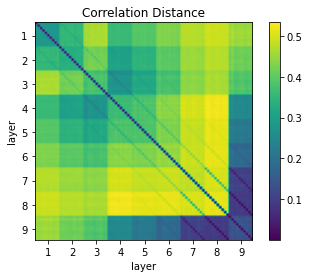

In [34]:
from matplotlib.pyplot import imshow
svcca_correlations = np.load('cca_correlations.npy')
svcca_correlations_distance = 1 - svcca_correlations
plt.title('Correlation Distance')
plt.xlabel('layer')
plt.xticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85],
           labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.yticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85],
           labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.ylabel('layer')

plt.imshow(svcca_correlations_distance)
plt.colorbar()

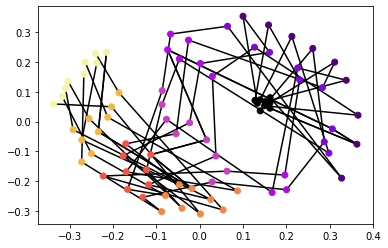

In [36]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2, dissimilarity='precomputed')

X_transformed = embedding.fit_transform(svcca_correlations_distance)
X_transformed.shape

colors = ['#f5f59d', '#f5b642', '#f58742', '#f55442', '#c940c5',
          '#b407ed', '#7d09d6', '#50017a', '#000000']
plt.plot(X_transformed[::10, 0], X_transformed[::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[1::10, 0], X_transformed[1::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[2::10, 0], X_transformed[2::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[3::10, 0], X_transformed[3::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[4::10, 0], X_transformed[4::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[5::10, 0], X_transformed[5::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[6::10, 0], X_transformed[6::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[7::10, 0], X_transformed[7::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[8::10, 0], X_transformed[8::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[::10, 0], X_transformed[::10, 1], linestyle='-', color='black', zorder=1)

plt.scatter(X_transformed[::10, 0], X_transformed[::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[1::10, 0], X_transformed[1::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[2::10, 0], X_transformed[2::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[3::10, 0], X_transformed[3::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[4::10, 0], X_transformed[4::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[5::10, 0], X_transformed[5::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[6::10, 0], X_transformed[6::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[7::10, 0], X_transformed[7::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[8::10, 0], X_transformed[8::10, 1], marker='o', color=colors, zorder=2)


In [4]:
import pwcca

# Get preprocessed data
_, testData = datasets.make_train_data(None)
x_predict, _ = datasets.make_predict_data(testData)


num_images = len(x_predict) # 1000
num_networks = 10
num_layers = 9
rep_list = [[], [], [], [], [], [], [], [], []]

# Loop through network instances
for i in [200, 202, 203, 206, 207, 302, 303, 304, 305, 306]:
    print('Working on model', str(i))
    K.clear_session()
    full_model = load_model('../outputs/models/primary/instance_' + str(i) + '.h5')
    inp = full_model.input
    # Loop through layers
    for j in range(num_layers):
        print('Layer', str(j))
        out = full_model.layers[j].output
        temp_model = Model(inputs=inp, outputs=out)
        # Predict on x_predict
        print('Getting representation...')
        representations = temp_model.predict(x_predict)
        print('Old shape:', representations.shape)
        # Average pool along spacial dimensions, transpose to fit shape (imgs, neurons)
        if (len(representations.shape) > 2):
            avg = np.mean(representations, axis=(1,2)).T
            print('Avg shape:', avg.shape)
        else:
            avg = representations.T
            print('No need to flatten')
        rep_list[j].append(avg)
        
print('Done preprocessing representations and thresholds, now CCA')
pwcca_correlations = np.empty((num_layers * num_networks, num_layers * num_networks))
for i in range(pwcca_correlations.shape[0]):
    for j in range(pwcca_correlations.shape[1]):
        print('Correlation', str(i), ',', str(j))
        
        layer_i = i // num_networks
        network_i = i % num_networks
        layer_j = j // num_networks
        network_j = j % num_networks
        
        # pwcca is order-dependent, so swap around to make symmetric
        if (i <= j):
            acts1 = rep_list[layer_i][network_i]
            acts2 = rep_list[layer_j][network_j]
        else:
            acts1 = rep_list[layer_j][network_j]
            acts2 = rep_list[layer_i][network_i]        
        
        # Do pwcca, acts1 needs to have dim <= acts2
        if (acts1.shape[0] <= acts2.shape[0]):
            pwcca_correlations[i, j] = pwcca.compute_pwcca(acts1, acts2, epsilon=1e-10)[0]
        else:
            pwcca_correlations[i, j] = pwcca.compute_pwcca(acts2, acts1, epsilon=1e-10)[0]

np.save('pwcca_correlations.npy', pwcca_correlations)
print('Done!')

Making train data...
GCN...
ZCA...
Done!
Making test data...
Done!
Working on model 200
Layer 0
Getting representation...
Old shape: (1000, 32, 32, 96)
Avg shape: (96, 1000)
Layer 1
Getting representation...
Old shape: (1000, 32, 32, 96)
Avg shape: (96, 1000)
Layer 2
Getting representation...
Old shape: (1000, 16, 16, 96)
Avg shape: (96, 1000)
Layer 3
Getting representation...
Old shape: (1000, 16, 16, 192)
Avg shape: (192, 1000)
Layer 4
Getting representation...
Old shape: (1000, 16, 16, 192)
Avg shape: (192, 1000)
Layer 5
Getting representation...
Old shape: (1000, 8, 8, 192)
Avg shape: (192, 1000)
Layer 6
Getting representation...
Old shape: (1000, 6, 6, 192)
Avg shape: (192, 1000)
Layer 7
Getting representation...
Old shape: (1000, 6, 6, 192)
Avg shape: (192, 1000)
Layer 8
Getting representation...
Old shape: (1000, 6, 6, 10)
Avg shape: (10, 1000)
Working on model 202
Layer 0
Getting representation...
Old shape: (1000, 32, 32, 96)
Avg shape: (96, 1000)
Layer 1
Getting representatio

Correlation 0 , 8
Correlation 0 , 9
Correlation 0 , 10
Correlation 0 , 11
Correlation 0 , 12
Correlation 0 , 13
Correlation 0 , 14
Correlation 0 , 15
Correlation 0 , 16
Correlation 0 , 17
Correlation 0 , 18
Correlation 0 , 19
Correlation 0 , 20
Correlation 0 , 21
Correlation 0 , 22
Correlation 0 , 23
Correlation 0 , 24
Correlation 0 , 25
Correlation 0 , 26
Correlation 0 , 27
Correlation 0 , 28
Correlation 0 , 29
Correlation 0 , 30
Correlation 0 , 31
Correlation 0 , 32
Correlation 0 , 33
Correlation 0 , 34
Correlation 0 , 35
Correlation 0 , 36
Correlation 0 , 37
Correlation 0 , 38
Correlation 0 , 39
Correlation 0 , 40
Correlation 0 , 41
Correlation 0 , 42
Correlation 0 , 43
Correlation 0 , 44
Correlation 0 , 45
Correlation 0 , 46
Correlation 0 , 47
Correlation 0 , 48
Correlation 0 , 49
Correlation 0 , 50
Correlation 0 , 51
Correlation 0 , 52
Correlation 0 , 53
Correlation 0 , 54
Correlation 0 , 55
Correlation 0 , 56
Correlation 0 , 57
Correlation 0 , 58
Correlation 0 , 59
Correlation 0 

Correlation 5 , 1
Correlation 5 , 2
Correlation 5 , 3
Correlation 5 , 4
Correlation 5 , 5
Correlation 5 , 6
Correlation 5 , 7
Correlation 5 , 8
Correlation 5 , 9
Correlation 5 , 10
Correlation 5 , 11
Correlation 5 , 12
Correlation 5 , 13
Correlation 5 , 14
Correlation 5 , 15
Correlation 5 , 16
Correlation 5 , 17
Correlation 5 , 18
Correlation 5 , 19
Correlation 5 , 20
Correlation 5 , 21
Correlation 5 , 22
Correlation 5 , 23
Correlation 5 , 24
Correlation 5 , 25
Correlation 5 , 26
Correlation 5 , 27
Correlation 5 , 28
Correlation 5 , 29
Correlation 5 , 30
Correlation 5 , 31
Correlation 5 , 32
Correlation 5 , 33
Correlation 5 , 34
Correlation 5 , 35
Correlation 5 , 36
Correlation 5 , 37
Correlation 5 , 38
Correlation 5 , 39
Correlation 5 , 40
Correlation 5 , 41
Correlation 5 , 42
Correlation 5 , 43
Correlation 5 , 44
Correlation 5 , 45
Correlation 5 , 46
Correlation 5 , 47
Correlation 5 , 48
Correlation 5 , 49
Correlation 5 , 50
Correlation 5 , 51
Correlation 5 , 52
Correlation 5 , 53
Co

Correlation 9 , 76
Correlation 9 , 77
Correlation 9 , 78
Correlation 9 , 79
Correlation 9 , 80
Correlation 9 , 81
Correlation 9 , 82
Correlation 9 , 83
Correlation 9 , 84
Correlation 9 , 85
Correlation 9 , 86
Correlation 9 , 87
Correlation 9 , 88
Correlation 9 , 89
Correlation 10 , 0
Correlation 10 , 1
Correlation 10 , 2
Correlation 10 , 3
Correlation 10 , 4
Correlation 10 , 5
Correlation 10 , 6
Correlation 10 , 7
Correlation 10 , 8
Correlation 10 , 9
Correlation 10 , 10
Correlation 10 , 11
Correlation 10 , 12
Correlation 10 , 13
Correlation 10 , 14
Correlation 10 , 15
Correlation 10 , 16
Correlation 10 , 17
Correlation 10 , 18
Correlation 10 , 19
Correlation 10 , 20
Correlation 10 , 21
Correlation 10 , 22
Correlation 10 , 23
Correlation 10 , 24
Correlation 10 , 25
Correlation 10 , 26
Correlation 10 , 27
Correlation 10 , 28
Correlation 10 , 29
Correlation 10 , 30
Correlation 10 , 31
Correlation 10 , 32
Correlation 10 , 33
Correlation 10 , 34
Correlation 10 , 35
Correlation 10 , 36
Corr

Correlation 14 , 40
Correlation 14 , 41
Correlation 14 , 42
Correlation 14 , 43
Correlation 14 , 44
Correlation 14 , 45
Correlation 14 , 46
Correlation 14 , 47
Correlation 14 , 48
Correlation 14 , 49
Correlation 14 , 50
Correlation 14 , 51
Correlation 14 , 52
Correlation 14 , 53
Correlation 14 , 54
Correlation 14 , 55
Correlation 14 , 56
Correlation 14 , 57
Correlation 14 , 58
Correlation 14 , 59
Correlation 14 , 60
Correlation 14 , 61
Correlation 14 , 62
Correlation 14 , 63
Correlation 14 , 64
Correlation 14 , 65
Correlation 14 , 66
Correlation 14 , 67
Correlation 14 , 68
Correlation 14 , 69
Correlation 14 , 70
Correlation 14 , 71
Correlation 14 , 72
Correlation 14 , 73
Correlation 14 , 74
Correlation 14 , 75
Correlation 14 , 76
Correlation 14 , 77
Correlation 14 , 78
Correlation 14 , 79
Correlation 14 , 80
Correlation 14 , 81
Correlation 14 , 82
Correlation 14 , 83
Correlation 14 , 84
Correlation 14 , 85
Correlation 14 , 86
Correlation 14 , 87
Correlation 14 , 88
Correlation 14 , 89


Correlation 19 , 3
Correlation 19 , 4
Correlation 19 , 5
Correlation 19 , 6
Correlation 19 , 7
Correlation 19 , 8
Correlation 19 , 9
Correlation 19 , 10
Correlation 19 , 11
Correlation 19 , 12
Correlation 19 , 13
Correlation 19 , 14
Correlation 19 , 15
Correlation 19 , 16
Correlation 19 , 17
Correlation 19 , 18
Correlation 19 , 19
Correlation 19 , 20
Correlation 19 , 21
Correlation 19 , 22
Correlation 19 , 23
Correlation 19 , 24
Correlation 19 , 25
Correlation 19 , 26
Correlation 19 , 27
Correlation 19 , 28
Correlation 19 , 29
Correlation 19 , 30
Correlation 19 , 31
Correlation 19 , 32
Correlation 19 , 33
Correlation 19 , 34
Correlation 19 , 35
Correlation 19 , 36
Correlation 19 , 37
Correlation 19 , 38
Correlation 19 , 39
Correlation 19 , 40
Correlation 19 , 41
Correlation 19 , 42
Correlation 19 , 43
Correlation 19 , 44
Correlation 19 , 45
Correlation 19 , 46
Correlation 19 , 47
Correlation 19 , 48
Correlation 19 , 49
Correlation 19 , 50
Correlation 19 , 51
Correlation 19 , 52
Correla

Correlation 23 , 56
Correlation 23 , 57
Correlation 23 , 58
Correlation 23 , 59
Correlation 23 , 60
Correlation 23 , 61
Correlation 23 , 62
Correlation 23 , 63
Correlation 23 , 64
Correlation 23 , 65
Correlation 23 , 66
Correlation 23 , 67
Correlation 23 , 68
Correlation 23 , 69
Correlation 23 , 70
Correlation 23 , 71
Correlation 23 , 72
Correlation 23 , 73
Correlation 23 , 74
Correlation 23 , 75
Correlation 23 , 76
Correlation 23 , 77
Correlation 23 , 78
Correlation 23 , 79
Correlation 23 , 80
Correlation 23 , 81
Correlation 23 , 82
Correlation 23 , 83
Correlation 23 , 84
Correlation 23 , 85
Correlation 23 , 86
Correlation 23 , 87
Correlation 23 , 88
Correlation 23 , 89
Correlation 24 , 0
Correlation 24 , 1
Correlation 24 , 2
Correlation 24 , 3
Correlation 24 , 4
Correlation 24 , 5
Correlation 24 , 6
Correlation 24 , 7
Correlation 24 , 8
Correlation 24 , 9
Correlation 24 , 10
Correlation 24 , 11
Correlation 24 , 12
Correlation 24 , 13
Correlation 24 , 14
Correlation 24 , 15
Correlatio

Correlation 28 , 23
Correlation 28 , 24
Correlation 28 , 25
Correlation 28 , 26
Correlation 28 , 27
Correlation 28 , 28
Correlation 28 , 29
Correlation 28 , 30
Correlation 28 , 31
Correlation 28 , 32
Correlation 28 , 33
Correlation 28 , 34
Correlation 28 , 35
Correlation 28 , 36
Correlation 28 , 37
Correlation 28 , 38
Correlation 28 , 39
Correlation 28 , 40
Correlation 28 , 41
Correlation 28 , 42
Correlation 28 , 43
Correlation 28 , 44
Correlation 28 , 45
Correlation 28 , 46
Correlation 28 , 47
Correlation 28 , 48
Correlation 28 , 49
Correlation 28 , 50
Correlation 28 , 51
Correlation 28 , 52
Correlation 28 , 53
Correlation 28 , 54
Correlation 28 , 55
Correlation 28 , 56
Correlation 28 , 57
Correlation 28 , 58
Correlation 28 , 59
Correlation 28 , 60
Correlation 28 , 61
Correlation 28 , 62
Correlation 28 , 63
Correlation 28 , 64
Correlation 28 , 65
Correlation 28 , 66
Correlation 28 , 67
Correlation 28 , 68
Correlation 28 , 69
Correlation 28 , 70
Correlation 28 , 71
Correlation 28 , 72


Correlation 32 , 75
Correlation 32 , 76
Correlation 32 , 77
Correlation 32 , 78
Correlation 32 , 79
Correlation 32 , 80
Correlation 32 , 81
Correlation 32 , 82
Correlation 32 , 83
Correlation 32 , 84
Correlation 32 , 85
Correlation 32 , 86
Correlation 32 , 87
Correlation 32 , 88
Correlation 32 , 89
Correlation 33 , 0
Correlation 33 , 1
Correlation 33 , 2
Correlation 33 , 3
Correlation 33 , 4
Correlation 33 , 5
Correlation 33 , 6
Correlation 33 , 7
Correlation 33 , 8
Correlation 33 , 9
Correlation 33 , 10
Correlation 33 , 11
Correlation 33 , 12
Correlation 33 , 13
Correlation 33 , 14
Correlation 33 , 15
Correlation 33 , 16
Correlation 33 , 17
Correlation 33 , 18
Correlation 33 , 19
Correlation 33 , 20
Correlation 33 , 21
Correlation 33 , 22
Correlation 33 , 23
Correlation 33 , 24
Correlation 33 , 25
Correlation 33 , 26
Correlation 33 , 27
Correlation 33 , 28
Correlation 33 , 29
Correlation 33 , 30
Correlation 33 , 31
Correlation 33 , 32
Correlation 33 , 33
Correlation 33 , 34
Correlatio

Correlation 37 , 39
Correlation 37 , 40
Correlation 37 , 41
Correlation 37 , 42
Correlation 37 , 43
Correlation 37 , 44
Correlation 37 , 45
Correlation 37 , 46
Correlation 37 , 47
Correlation 37 , 48
Correlation 37 , 49
Correlation 37 , 50
Correlation 37 , 51
Correlation 37 , 52
Correlation 37 , 53
Correlation 37 , 54
Correlation 37 , 55
Correlation 37 , 56
Correlation 37 , 57
Correlation 37 , 58
Correlation 37 , 59
Correlation 37 , 60
Correlation 37 , 61
Correlation 37 , 62
Correlation 37 , 63
Correlation 37 , 64
Correlation 37 , 65
Correlation 37 , 66
Correlation 37 , 67
Correlation 37 , 68
Correlation 37 , 69
Correlation 37 , 70
Correlation 37 , 71
Correlation 37 , 72
Correlation 37 , 73
Correlation 37 , 74
Correlation 37 , 75
Correlation 37 , 76
Correlation 37 , 77
Correlation 37 , 78
Correlation 37 , 79
Correlation 37 , 80
Correlation 37 , 81
Correlation 37 , 82
Correlation 37 , 83
Correlation 37 , 84
Correlation 37 , 85
Correlation 37 , 86
Correlation 37 , 87
Correlation 37 , 88


Correlation 42 , 1
Correlation 42 , 2
Correlation 42 , 3
Correlation 42 , 4
Correlation 42 , 5
Correlation 42 , 6
Correlation 42 , 7
Correlation 42 , 8
Correlation 42 , 9
Correlation 42 , 10
Correlation 42 , 11
Correlation 42 , 12
Correlation 42 , 13
Correlation 42 , 14
Correlation 42 , 15
Correlation 42 , 16
Correlation 42 , 17
Correlation 42 , 18
Correlation 42 , 19
Correlation 42 , 20
Correlation 42 , 21
Correlation 42 , 22
Correlation 42 , 23
Correlation 42 , 24
Correlation 42 , 25
Correlation 42 , 26
Correlation 42 , 27
Correlation 42 , 28
Correlation 42 , 29
Correlation 42 , 30
Correlation 42 , 31
Correlation 42 , 32
Correlation 42 , 33
Correlation 42 , 34
Correlation 42 , 35
Correlation 42 , 36
Correlation 42 , 37
Correlation 42 , 38
Correlation 42 , 39
Correlation 42 , 40
Correlation 42 , 41
Correlation 42 , 42
Correlation 42 , 43
Correlation 42 , 44
Correlation 42 , 45
Correlation 42 , 46
Correlation 42 , 47
Correlation 42 , 48
Correlation 42 , 49
Correlation 42 , 50
Correlati

Correlation 46 , 55
Correlation 46 , 56
Correlation 46 , 57
Correlation 46 , 58
Correlation 46 , 59
Correlation 46 , 60
Correlation 46 , 61
Correlation 46 , 62
Correlation 46 , 63
Correlation 46 , 64
Correlation 46 , 65
Correlation 46 , 66
Correlation 46 , 67
Correlation 46 , 68
Correlation 46 , 69
Correlation 46 , 70
Correlation 46 , 71
Correlation 46 , 72
Correlation 46 , 73
Correlation 46 , 74
Correlation 46 , 75
Correlation 46 , 76
Correlation 46 , 77
Correlation 46 , 78
Correlation 46 , 79
Correlation 46 , 80
Correlation 46 , 81
Correlation 46 , 82
Correlation 46 , 83
Correlation 46 , 84
Correlation 46 , 85
Correlation 46 , 86
Correlation 46 , 87
Correlation 46 , 88
Correlation 46 , 89
Correlation 47 , 0
Correlation 47 , 1
Correlation 47 , 2
Correlation 47 , 3
Correlation 47 , 4
Correlation 47 , 5
Correlation 47 , 6
Correlation 47 , 7
Correlation 47 , 8
Correlation 47 , 9
Correlation 47 , 10
Correlation 47 , 11
Correlation 47 , 12
Correlation 47 , 13
Correlation 47 , 14
Correlatio

Correlation 51 , 19
Correlation 51 , 20
Correlation 51 , 21
Correlation 51 , 22
Correlation 51 , 23
Correlation 51 , 24
Correlation 51 , 25
Correlation 51 , 26
Correlation 51 , 27
Correlation 51 , 28
Correlation 51 , 29
Correlation 51 , 30
Correlation 51 , 31
Correlation 51 , 32
Correlation 51 , 33
Correlation 51 , 34
Correlation 51 , 35
Correlation 51 , 36
Correlation 51 , 37
Correlation 51 , 38
Correlation 51 , 39
Correlation 51 , 40
Correlation 51 , 41
Correlation 51 , 42
Correlation 51 , 43
Correlation 51 , 44
Correlation 51 , 45
Correlation 51 , 46
Correlation 51 , 47
Correlation 51 , 48
Correlation 51 , 49
Correlation 51 , 50
Correlation 51 , 51
Correlation 51 , 52
Correlation 51 , 53
Correlation 51 , 54
Correlation 51 , 55
Correlation 51 , 56
Correlation 51 , 57
Correlation 51 , 58
Correlation 51 , 59
Correlation 51 , 60
Correlation 51 , 61
Correlation 51 , 62
Correlation 51 , 63
Correlation 51 , 64
Correlation 51 , 65
Correlation 51 , 66
Correlation 51 , 67
Correlation 51 , 68


Correlation 55 , 71
Correlation 55 , 72
Correlation 55 , 73
Correlation 55 , 74
Correlation 55 , 75
Correlation 55 , 76
Correlation 55 , 77
Correlation 55 , 78
Correlation 55 , 79
Correlation 55 , 80
Correlation 55 , 81
Correlation 55 , 82
Correlation 55 , 83
Correlation 55 , 84
Correlation 55 , 85
Correlation 55 , 86
Correlation 55 , 87
Correlation 55 , 88
Correlation 55 , 89
Correlation 56 , 0
Correlation 56 , 1
Correlation 56 , 2
Correlation 56 , 3
Correlation 56 , 4
Correlation 56 , 5
Correlation 56 , 6
Correlation 56 , 7
Correlation 56 , 8
Correlation 56 , 9
Correlation 56 , 10
Correlation 56 , 11
Correlation 56 , 12
Correlation 56 , 13
Correlation 56 , 14
Correlation 56 , 15
Correlation 56 , 16
Correlation 56 , 17
Correlation 56 , 18
Correlation 56 , 19
Correlation 56 , 20
Correlation 56 , 21
Correlation 56 , 22
Correlation 56 , 23
Correlation 56 , 24
Correlation 56 , 25
Correlation 56 , 26
Correlation 56 , 27
Correlation 56 , 28
Correlation 56 , 29
Correlation 56 , 30
Correlatio

Correlation 60 , 35
Correlation 60 , 36
Correlation 60 , 37
Correlation 60 , 38
Correlation 60 , 39
Correlation 60 , 40
Correlation 60 , 41
Correlation 60 , 42
Correlation 60 , 43
Correlation 60 , 44
Correlation 60 , 45
Correlation 60 , 46
Correlation 60 , 47
Correlation 60 , 48
Correlation 60 , 49
Correlation 60 , 50
Correlation 60 , 51
Correlation 60 , 52
Correlation 60 , 53
Correlation 60 , 54
Correlation 60 , 55
Correlation 60 , 56
Correlation 60 , 57
Correlation 60 , 58
Correlation 60 , 59
Correlation 60 , 60
Correlation 60 , 61
Correlation 60 , 62
Correlation 60 , 63
Correlation 60 , 64
Correlation 60 , 65
Correlation 60 , 66
Correlation 60 , 67
Correlation 60 , 68
Correlation 60 , 69
Correlation 60 , 70
Correlation 60 , 71
Correlation 60 , 72
Correlation 60 , 73
Correlation 60 , 74
Correlation 60 , 75
Correlation 60 , 76
Correlation 60 , 77
Correlation 60 , 78
Correlation 60 , 79
Correlation 60 , 80
Correlation 60 , 81
Correlation 60 , 82
Correlation 60 , 83
Correlation 60 , 84


Correlation 64 , 88
Correlation 64 , 89
Correlation 65 , 0
Correlation 65 , 1
Correlation 65 , 2
Correlation 65 , 3
Correlation 65 , 4
Correlation 65 , 5
Correlation 65 , 6
Correlation 65 , 7
Correlation 65 , 8
Correlation 65 , 9
Correlation 65 , 10
Correlation 65 , 11
Correlation 65 , 12
Correlation 65 , 13
Correlation 65 , 14
Correlation 65 , 15
Correlation 65 , 16
Correlation 65 , 17
Correlation 65 , 18
Correlation 65 , 19
Correlation 65 , 20
Correlation 65 , 21
Correlation 65 , 22
Correlation 65 , 23
Correlation 65 , 24
Correlation 65 , 25
Correlation 65 , 26
Correlation 65 , 27
Correlation 65 , 28
Correlation 65 , 29
Correlation 65 , 30
Correlation 65 , 31
Correlation 65 , 32
Correlation 65 , 33
Correlation 65 , 34
Correlation 65 , 35
Correlation 65 , 36
Correlation 65 , 37
Correlation 65 , 38
Correlation 65 , 39
Correlation 65 , 40
Correlation 65 , 41
Correlation 65 , 42
Correlation 65 , 43
Correlation 65 , 44
Correlation 65 , 45
Correlation 65 , 46
Correlation 65 , 47
Correlatio

Correlation 69 , 51
Correlation 69 , 52
Correlation 69 , 53
Correlation 69 , 54
Correlation 69 , 55
Correlation 69 , 56
Correlation 69 , 57
Correlation 69 , 58
Correlation 69 , 59
Correlation 69 , 60
Correlation 69 , 61
Correlation 69 , 62
Correlation 69 , 63
Correlation 69 , 64
Correlation 69 , 65
Correlation 69 , 66
Correlation 69 , 67
Correlation 69 , 68
Correlation 69 , 69
Correlation 69 , 70
Correlation 69 , 71
Correlation 69 , 72
Correlation 69 , 73
Correlation 69 , 74
Correlation 69 , 75
Correlation 69 , 76
Correlation 69 , 77
Correlation 69 , 78
Correlation 69 , 79
Correlation 69 , 80
Correlation 69 , 81
Correlation 69 , 82
Correlation 69 , 83
Correlation 69 , 84
Correlation 69 , 85
Correlation 69 , 86
Correlation 69 , 87
Correlation 69 , 88
Correlation 69 , 89
Correlation 70 , 0
Correlation 70 , 1
Correlation 70 , 2
Correlation 70 , 3
Correlation 70 , 4
Correlation 70 , 5
Correlation 70 , 6
Correlation 70 , 7
Correlation 70 , 8
Correlation 70 , 9
Correlation 70 , 10
Correlatio

Correlation 74 , 14
Correlation 74 , 15
Correlation 74 , 16
Correlation 74 , 17
Correlation 74 , 18
Correlation 74 , 19
Correlation 74 , 20
Correlation 74 , 21
Correlation 74 , 22
Correlation 74 , 23
Correlation 74 , 24
Correlation 74 , 25
Correlation 74 , 26
Correlation 74 , 27
Correlation 74 , 28
Correlation 74 , 29
Correlation 74 , 30
Correlation 74 , 31
Correlation 74 , 32
Correlation 74 , 33
Correlation 74 , 34
Correlation 74 , 35
Correlation 74 , 36
Correlation 74 , 37
Correlation 74 , 38
Correlation 74 , 39
Correlation 74 , 40
Correlation 74 , 41
Correlation 74 , 42
Correlation 74 , 43
Correlation 74 , 44
Correlation 74 , 45
Correlation 74 , 46
Correlation 74 , 47
Correlation 74 , 48
Correlation 74 , 49
Correlation 74 , 50
Correlation 74 , 51
Correlation 74 , 52
Correlation 74 , 53
Correlation 74 , 54
Correlation 74 , 55
Correlation 74 , 56
Correlation 74 , 57
Correlation 74 , 58
Correlation 74 , 59
Correlation 74 , 60
Correlation 74 , 61
Correlation 74 , 62
Correlation 74 , 63


Correlation 78 , 66
Correlation 78 , 67
Correlation 78 , 68
Correlation 78 , 69
Correlation 78 , 70
Correlation 78 , 71
Correlation 78 , 72
Correlation 78 , 73
Correlation 78 , 74
Correlation 78 , 75
Correlation 78 , 76
Correlation 78 , 77
Correlation 78 , 78
Correlation 78 , 79
Correlation 78 , 80
Correlation 78 , 81
Correlation 78 , 82
Correlation 78 , 83
Correlation 78 , 84
Correlation 78 , 85
Correlation 78 , 86
Correlation 78 , 87
Correlation 78 , 88
Correlation 78 , 89
Correlation 79 , 0
Correlation 79 , 1
Correlation 79 , 2
Correlation 79 , 3
Correlation 79 , 4
Correlation 79 , 5
Correlation 79 , 6
Correlation 79 , 7
Correlation 79 , 8
Correlation 79 , 9
Correlation 79 , 10
Correlation 79 , 11
Correlation 79 , 12
Correlation 79 , 13
Correlation 79 , 14
Correlation 79 , 15
Correlation 79 , 16
Correlation 79 , 17
Correlation 79 , 18
Correlation 79 , 19
Correlation 79 , 20
Correlation 79 , 21
Correlation 79 , 22
Correlation 79 , 23
Correlation 79 , 24
Correlation 79 , 25
Correlatio

Correlation 83 , 32
Correlation 83 , 33
Correlation 83 , 34
Correlation 83 , 35
Correlation 83 , 36
Correlation 83 , 37
Correlation 83 , 38
Correlation 83 , 39
Correlation 83 , 40
Correlation 83 , 41
Correlation 83 , 42
Correlation 83 , 43
Correlation 83 , 44
Correlation 83 , 45
Correlation 83 , 46
Correlation 83 , 47
Correlation 83 , 48
Correlation 83 , 49
Correlation 83 , 50
Correlation 83 , 51
Correlation 83 , 52
Correlation 83 , 53
Correlation 83 , 54
Correlation 83 , 55
Correlation 83 , 56
Correlation 83 , 57
Correlation 83 , 58
Correlation 83 , 59
Correlation 83 , 60
Correlation 83 , 61
Correlation 83 , 62
Correlation 83 , 63
Correlation 83 , 64
Correlation 83 , 65
Correlation 83 , 66
Correlation 83 , 67
Correlation 83 , 68
Correlation 83 , 69
Correlation 83 , 70
Correlation 83 , 71
Correlation 83 , 72
Correlation 83 , 73
Correlation 83 , 74
Correlation 83 , 75
Correlation 83 , 76
Correlation 83 , 77
Correlation 83 , 78
Correlation 83 , 79
Correlation 83 , 80
Correlation 83 , 81


Correlation 88 , 3
Correlation 88 , 4
Correlation 88 , 5
Correlation 88 , 6
Correlation 88 , 7
Correlation 88 , 8
Correlation 88 , 9
Correlation 88 , 10
Correlation 88 , 11
Correlation 88 , 12
Correlation 88 , 13
Correlation 88 , 14
Correlation 88 , 15
Correlation 88 , 16
Correlation 88 , 17
Correlation 88 , 18
Correlation 88 , 19
Correlation 88 , 20
Correlation 88 , 21
Correlation 88 , 22
Correlation 88 , 23
Correlation 88 , 24
Correlation 88 , 25
Correlation 88 , 26
Correlation 88 , 27
Correlation 88 , 28
Correlation 88 , 29
Correlation 88 , 30
Correlation 88 , 31
Correlation 88 , 32
Correlation 88 , 33
Correlation 88 , 34
Correlation 88 , 35
Correlation 88 , 36
Correlation 88 , 37
Correlation 88 , 38
Correlation 88 , 39
Correlation 88 , 40
Correlation 88 , 41
Correlation 88 , 42
Correlation 88 , 43
Correlation 88 , 44
Correlation 88 , 45
Correlation 88 , 46
Correlation 88 , 47
Correlation 88 , 48
Correlation 88 , 49
Correlation 88 , 50
Correlation 88 , 51
Correlation 88 , 52
Correla

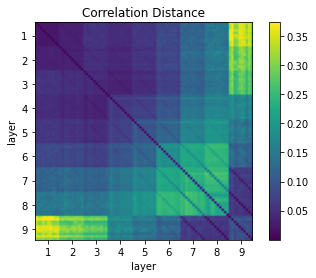

In [5]:
from matplotlib.pyplot import imshow
pwcca_correlations = np.load('pwcca_correlations.npy')
pwcca_correlations_distance = 1 - pwcca_correlations
plt.title('Correlation Distance')
plt.xlabel('layer')
plt.xticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85],
           labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.yticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85],
           labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.ylabel('layer')

plt.imshow(pwcca_correlations_distance)
plt.colorbar()

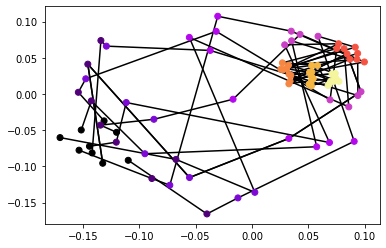

In [39]:
# pwcca_correlations_distance.shape
from sklearn.manifold import MDS
embedding = MDS(n_components=2, dissimilarity='precomputed')

X_transformed = embedding.fit_transform(pwcca_correlations_distance.astype('float64'))
X_transformed.shape

colors = ['#f5f59d', '#f5b642', '#f58742', '#f55442', '#c940c5',
          '#b407ed', '#7d09d6', '#50017a', '#000000']
plt.plot(X_transformed[::10, 0], X_transformed[::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[1::10, 0], X_transformed[1::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[2::10, 0], X_transformed[2::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[3::10, 0], X_transformed[3::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[4::10, 0], X_transformed[4::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[5::10, 0], X_transformed[5::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[6::10, 0], X_transformed[6::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[7::10, 0], X_transformed[7::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[8::10, 0], X_transformed[8::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[::10, 0], X_transformed[::10, 1], linestyle='-', color='black', zorder=1)

plt.scatter(X_transformed[::10, 0], X_transformed[::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[1::10, 0], X_transformed[1::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[2::10, 0], X_transformed[2::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[3::10, 0], X_transformed[3::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[4::10, 0], X_transformed[4::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[5::10, 0], X_transformed[5::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[6::10, 0], X_transformed[6::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[7::10, 0], X_transformed[7::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[8::10, 0], X_transformed[8::10, 1], marker='o', color=colors, zorder=2)
